In [105]:
# Standard library imports
import itertools
import os
import random
import re
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import stanza
import tensorflow as tf
import torch
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from nltk.corpus import stopwords as nltk_stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.util import *
from openai import OpenAI
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from spellchecker import SpellChecker
from textblob import TextBlob
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from xgboost import XGBClassifier
import contractions
from datasets import Dataset
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, GRU, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2

# Local application/library specific imports

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Suppress warnings
warnings.filterwarnings('ignore')

# Enable progress bar for pandas apply
tqdm.pandas()

[nltk_data] Downloading package punkt to /Users/nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nuno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nuno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nuno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 1 Análise de Sentimento

### 1.1 Dados

amazon_reviews: Conjunto não balanceado, com cerca de 50000 reviews de produtos da empresa Amazon, anotadas com as etiquetas “positive” e “negative”.

In [2]:

# Carregar os dados de treino
train_data = pd.read_csv("amazon_reviews_train.csv")

# Carregar os dados de teste
test_data = pd.read_csv("amazon_reviews_test.csv")

In [3]:
test_data["sentiment"] = test_data["sentiment"].map({"positive": 1, "negative": 0})


In [4]:
# Verificar o tamanho dos dados
print(train_data.shape)
print(test_data.shape)

(48902, 2)
(2417, 2)


In [5]:
# Verificar os NA no conjunto de treino
print("Null values:",train_data.isnull().values.sum())
print("NA values:", train_data.isna().values.any())

# Verificar os NA no conjunto de teste
print("Null values:",test_data.isnull().values.sum())
print("NA values:", test_data.isna().values.any())

Null values: 0
NA values: False
Null values: 0
NA values: False


In [6]:
train_data.head()

,sentiment,review
0,negative,Product arrived labeled as Jumbo Salted Peanut...
1,positive,This is a confection that has been around a fe...
2,negative,If you are looking for the secret ingredient i...
3,positive,Great taffy at a great price. There was a wid...
4,positive,This saltwater taffy had great flavors and was...


In [7]:
# Número de documentos
num_docs_train = len(train_data)
num_docs_test = len(test_data)

print(f"Number of documents in training set: {num_docs_train}")
print(f"Number of documents in test set: {num_docs_test}")

# Distribuição de etiquetas
label_distribution_train = train_data['sentiment'].value_counts()
label_distribution_test = test_data['sentiment'].value_counts()

print("\nLabel distribution in training set:")
print(label_distribution_train)

print("\nLabel distribution in test set:")
print(label_distribution_test)

Number of documents in training set: 48902
Number of documents in test set: 2417

Label distribution in training set:
sentiment
positive    37835
negative    11067
Name: count, dtype: int64

Label distribution in test set:
sentiment
1    1676
0     741
Name: count, dtype: int64


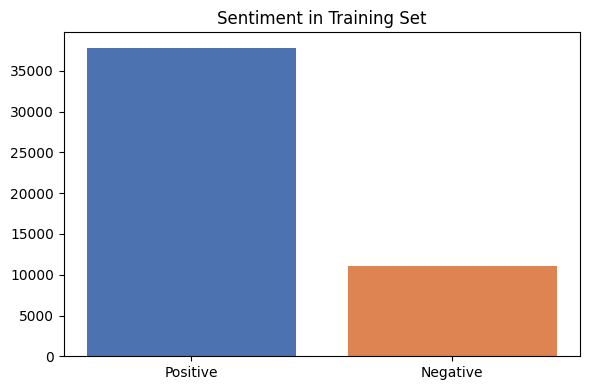

In [8]:
# Distribuição conjunto de treino
import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('deep')

plt.figure(figsize=(6,4), tight_layout=True)
plt.bar(x=['Positive', 'Negative'],
        height=train_data['sentiment'].value_counts(),
        color=colors[:2])
plt.title('Sentiment in Training Set')
plt.show()

Conjunto de treino não balanceado 

In [9]:

# Configura o undersampler
rus = RandomUnderSampler(random_state=42)

# Separa os dados e as etiquetas
X_train = train_data[['review']]
y_train = train_data['sentiment']

# Aplica o undersampling
X_res, y_res = rus.fit_resample(X_train, y_train)

# Verifica o novo balanceamento das classes
#print(pd.Series(y_res).value_counts())

# Criar um novo dataframe com os dados balanceados
train_data_balanced = pd.concat([X_res, pd.Series(y_res, name='sentiment')], axis=1)

print(train_data['sentiment'].value_counts())
print(train_data_balanced['sentiment'].value_counts())

sentiment
positive    37835
negative    11067
Name: count, dtype: int64
sentiment
negative    11067
positive    11067
Name: count, dtype: int64


### 1.2 Definição de um baseline usando ferramentas já existentes

- TextBlob
- Vader Sentiment
- Stanza

In [10]:
# Verificar os nomes das colunas
print(test_data.columns)

# Função para prever o sentimento com TextBlob
def predict_sentiment(text):
    analysis = TextBlob(text)
    return "positive" if analysis.sentiment.polarity >= 0 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_TextBlob"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["predicted_sentiment_TextBlob"] = test_data["predicted_sentiment_TextBlob"].map({"positive": 1, "negative": 0})

print(test_data["sentiment"].value_counts())

# Calcular as métricas de avaliação
print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_TextBlob"] ))

Index(['sentiment', 'review'], dtype='object')
sentiment
1    1676
0     741
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.74      0.36      0.48       741
           1       0.77      0.94      0.85      1676

    accuracy                           0.76      2417
   macro avg       0.75      0.65      0.67      2417
weighted avg       0.76      0.76      0.74      2417



In [11]:
# Inicializar o analisador de sentimentos VADER
analyzer = SentimentIntensityAnalyzer()

# Função para prever o sentimento com VADER
def predict_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return "positive" if scores["compound"] >= 0 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_VADER"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["predicted_sentiment_VADER"] = test_data["predicted_sentiment_VADER"].map({"positive": 1, "negative": 0})

print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_VADER"] ))

              precision    recall  f1-score   support

           0       0.82      0.39      0.53       741
           1       0.78      0.96      0.86      1676

    accuracy                           0.79      2417
   macro avg       0.80      0.68      0.70      2417
weighted avg       0.79      0.79      0.76      2417



In [12]:
# Inicializar o pipeline NLP Stanza
nlp = stanza.Pipeline("en", processors="tokenize,sentiment")


# Função para prever o sentimento com Stanza
def predict_sentiment(text):
    doc = nlp(text)
    sentiment_scores = [sentence.sentiment for sentence in doc.sentences]
    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    return "positive" if avg_sentiment >= 1 else "negative"


# Aplicar a função de previsão de sentimento aos dados de teste
test_data["predicted_sentiment_Stanza"] = test_data["review"].apply(predict_sentiment)

# Converter rótulos de string para binários
test_data["predicted_sentiment_Stanza"] = test_data["predicted_sentiment_Stanza"].map(
    {"positive": 1, "negative": 0}
)

# Calcular as métricas de avaliação
print(classification_report(test_data["sentiment"], test_data["predicted_sentiment_Stanza"] ))

2024-04-20 11:39:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-20 11:39:13 INFO: Downloaded file to /Users/nuno/stanza_resources/resources.json
2024-04-20 11:39:13 WARNING: Language en package default expects mwt, which has been added
2024-04-20 11:39:14 INFO: Loading these models for language: en (English):
| Processor | Package        |
------------------------------
| tokenize  | combined       |
| mwt       | combined       |
| sentiment | sstplus_charlm |

2024-04-20 11:39:14 INFO: Using device: cpu
2024-04-20 11:39:14 INFO: Loading: tokenize
2024-04-20 11:39:14 INFO: Loading: mwt
2024-04-20 11:39:14 INFO: Loading: sentiment
2024-04-20 11:39:15 INFO: Done loading processors!


              precision    recall  f1-score   support

           0       0.69      0.78      0.73       741
           1       0.90      0.85      0.87      1676

    accuracy                           0.83      2417
   macro avg       0.79      0.81      0.80      2417
weighted avg       0.83      0.83      0.83      2417



### 1.3 Preparação de dados e aplicação de um léxico de sentimentos

**Léxicos de polaridade** são recursos valiosos em processamento de linguagem natural (NLP), particularmente úteis para tarefas como análise de sentimentos, onde o objetivo é determinar a atitude ou emoção expressa num texto. Esses léxicos consistem em listas de palavras, cada uma associada a uma pontuação ou etiqueta que indica se a palavra tem uma conotação positiva, negativa ou neutra. Alguns léxicos também incluem intensidades para refletir o grau de emoção. 

- NRC Word-Emotion Association Lexicon (EmoLex)

In [13]:
# Lista de palavras inglesas e o seu respetivo sentimento (positivo ou negativo)
emolex = pd.read_csv(
    "NCR-lexicon.txt",
    skiprows=0,
    sep="\t",
)

emolex = emolex[["English Word", "negative", "positive"]]

emolex_dict = {row["English Word"]: (row["positive"], row["negative"]) for index, row in emolex.iterrows()}

emolex.head(10)

,English Word,negative,positive
0,aback,0,0
1,abacus,0,0
2,abandon,1,0
3,abandoned,1,0
4,abandonment,1,0
5,abate,0,0
6,abatement,0,0
7,abba,0,1
8,abbot,0,0
9,abbreviate,0,0


In [14]:
emolex_dict = {row["English Word"]: (row["positive"], row["negative"]) for index, row in emolex.iterrows()}

emolex_dict['happy']

(1, 0)

- Afinn Lexicon ()

Este léxico atribui a cada palavra uma pontuação de -5 a 5, indicando a intensidade do sentimento negativo ou positivo. É útil em contextos onde a intensidade precisa ser medida.

In [15]:
afinn = pd.read_csv("Afinn.csv", encoding="latin1")

afinn.head(10)

,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2
5,abductions,-2
6,abhor,-3
7,abhorred,-3
8,abhorrent,-3
9,abhors,-3


In [16]:
afinn_dict = {row["word"]: row["value"] for index, row in afinn.iterrows()}

afinn_dict['happy']

3

- Bing Lexicon ()

Este léxico é frequentemente usado em análise de sentimentos para identificar e contar o número de palavras positivas e negativas num texto.

In [17]:
bing = pd.read_csv("Bing.csv")

bing.head(10)

,word,sentiment
0,2-faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative
5,abominate,negative
6,abomination,negative
7,abort,negative
8,aborted,negative
9,aborts,negative


In [18]:
# Adiciona colunas binárias para os sentimentos
bing['negative'] = (bing['sentiment'] == 'negative').astype(int)
bing['positive'] = (bing['sentiment'] == 'positive').astype(int)

bing = bing.drop('sentiment', axis=1)

bing_dict = {row["word"]: (row["positive"], row["negative"]) for index, row in bing.iterrows()}

bing_dict['happy']

(1, 0)

Pré-processamento

**Wordclouds** testar no fim com os modelos e respetivo tratamento do texto

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model

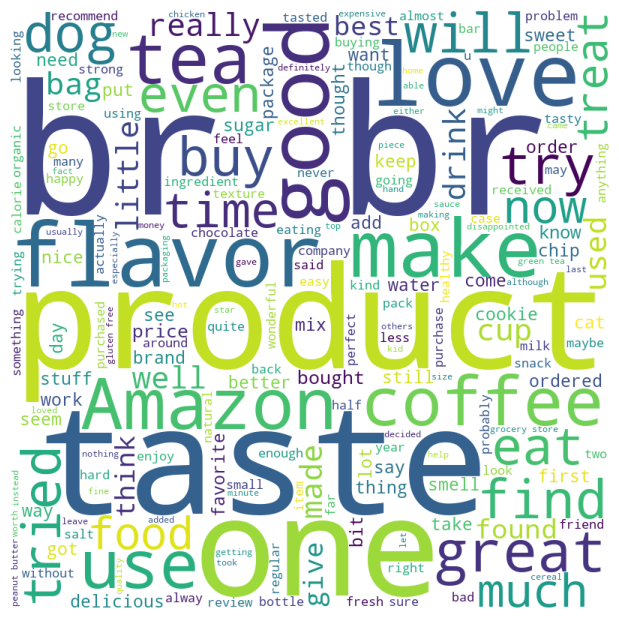

In [19]:
# Concatena todas as reviews em uma única string
text = " ".join(review for review in train_data['review'])

# Crie a instância WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(text)

# Plote o WordCloud                    
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [20]:
# Top 20 palavras mais comuns
words = re.findall(r'\w+', ' '.join(train_data['review'].str.lower()))
top = Counter(words)
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,154572
1,i,142088
2,and,105446
3,a,100114
4,it,88910
5,to,82734
6,of,65062
7,is,59759
8,this,56492
9,br,48939


- Limpeza do texto

In [21]:
# Função de limpeza de texto
def clean(text):
    
    # Transformar em minúsculas
    text = text.lower()
    # Remover código HTML
    text = re.sub(r"<[^>]+>", "", text)
    # Remover URLs
    text = re.sub(r"http\S+|www\S+|https?\:\/\/\S+", "", text)
    # Remover menções a usuários (não é comum em reviews da Amazon)
    text = re.sub(r"@\w+", "", text)
    # Remover hashtags (também não é comum em reviews da Amazon)
    text = re.sub(r"#\w+", "", text)
    # Remover entidades HTML (&amp;, &lt;, etc.)
    text = re.sub(r"&\w+;", "", text)
    # Remover números (avaliações numéricas, preços, etc.)
    text = re.sub(r"\d+", "", text)
    # Substituir caracteres de pontuação por espaços, exceto apostrofes dentro de palavras
    text = re.sub(r"[^\w\s']", " ", text)
    # Remover espaços múltiplos e linhas novas
    text = re.sub(r"\s+", " ", text)
    #Remover espaços no início e no fim
    text = text.strip()

    return text


train_clean = train_data["review"].apply(clean)
test_clean = test_data["review"].apply(clean)

In [22]:
train_data["review"][157]

"Hi, I have to have black tea everyday. I have done it in the past 25 years and it's a habit of mine. Ahmad tea is one of my favorite brands and I highly recommend it if you like black tea. I think this is going to remain my favorite for the next 100 years or so :)"

In [23]:
train_clean[157]

"hi i have to have black tea everyday i have done it in the past years and it's a habit of mine ahmad tea is one of my favorite brands and i highly recommend it if you like black tea i think this is going to remain my favorite for the next years or so"

- Tokenização

In [24]:
# Função de tokenização
def tokenize(text):
    return word_tokenize(text)


train_tok = train_data["review"].apply(tokenize)

test_tok = test_data["review"].apply(tokenize)

[nltk_data] Downloading package punkt to /Users/nuno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
train_tok[18]

['The',
 'candy',
 'is',
 'just',
 'red',
 ',',
 'No',
 'flavor',
 '.',
 'Just',
 'plan',
 'and',
 'chewy',
 '.',
 'I',
 'would',
 'never',
 'buy',
 'them',
 'again']

- StopWords

In [26]:
# Função que remove stopwords
def remove_stopwords(text):
    
    try:
        words = word_tokenize(text)
    except:
        words = text
        
    words = [word for word in words if word not in nltk_stopwords.words('english')]
    return words

train_stopwords = train_data["review"].apply(remove_stopwords)
test_stopwords = test_data["review"].apply(remove_stopwords)

In [27]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [28]:
train_stopwords[28]

['I',
 'ordered',
 'wife',
 'reccomended',
 'daughter',
 '.',
 'She',
 'almost',
 'every',
 'morning',
 'likes',
 'flavors',
 '.',
 'She',
 "'s",
 'happy',
 ',',
 'I',
 "'m",
 'happy',
 '!',
 '!',
 '!',
 '<',
 'br',
 '/',
 '>',
 '<',
 'href=',
 "''",
 'http',
 ':',
 '//www.amazon.com/gp/product/B001EO5QW8',
 "''",
 '>',
 'McCANN',
 "'S",
 'Instant',
 'Irish',
 'Oatmeal',
 ',',
 'Variety',
 'Pack',
 'Regular',
 ',',
 'Apples',
 '&',
 'Cinnamon',
 ',',
 'Maple',
 '&',
 'Brown',
 'Sugar',
 ',',
 '10-Count',
 'Boxes',
 '(',
 'Pack',
 '6',
 ')',
 '<',
 '/a',
 '>']

- Stemming

In [29]:
# Função de stemming
def stem(text):
    stemmer = PorterStemmer()
    try:
        words = word_tokenize(text)
    except:
        words = text
    words = [stemmer.stem(word) for word in words]
    return words

train_stem = train_data['review'].apply(stem)
test_stem = test_data['review'].apply(stem)


In [30]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [31]:
train_stem[28]

['i',
 'order',
 'thi',
 'for',
 'my',
 'wife',
 'as',
 'it',
 'wa',
 'reccomend',
 'by',
 'our',
 'daughter',
 '.',
 'she',
 'ha',
 'thi',
 'almost',
 'everi',
 'morn',
 'and',
 'like',
 'all',
 'flavor',
 '.',
 'she',
 "'s",
 'happi',
 ',',
 'i',
 "'m",
 'happi',
 '!',
 '!',
 '!',
 '<',
 'br',
 '/',
 '>',
 '<',
 'a',
 'href=',
 "''",
 'http',
 ':',
 '//www.amazon.com/gp/product/b001eo5qw8',
 "''",
 '>',
 'mccann',
 "'s",
 'instant',
 'irish',
 'oatmeal',
 ',',
 'varieti',
 'pack',
 'of',
 'regular',
 ',',
 'appl',
 '&',
 'cinnamon',
 ',',
 'and',
 'mapl',
 '&',
 'brown',
 'sugar',
 ',',
 '10-count',
 'box',
 '(',
 'pack',
 'of',
 '6',
 ')',
 '<',
 '/a',
 '>']

- Lematização

In [32]:
# Função de lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()

    try:
        words = word_tokenize(text)
    except:
        words = text
        
    words = [lemmatizer.lemmatize(word, "v") for word in words]
    return words

train_lemmatized = train_data["review"].apply(lemmatize)
test_lemmatized = test_data["review"].apply(lemmatize)

In [33]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [34]:
train_lemmatized[28]

['I',
 'order',
 'this',
 'for',
 'my',
 'wife',
 'as',
 'it',
 'be',
 'reccomended',
 'by',
 'our',
 'daughter',
 '.',
 'She',
 'have',
 'this',
 'almost',
 'every',
 'morning',
 'and',
 'like',
 'all',
 'flavor',
 '.',
 'She',
 "'s",
 'happy',
 ',',
 'I',
 "'m",
 'happy',
 '!',
 '!',
 '!',
 '<',
 'br',
 '/',
 '>',
 '<',
 'a',
 'href=',
 "''",
 'http',
 ':',
 '//www.amazon.com/gp/product/B001EO5QW8',
 "''",
 '>',
 'McCANN',
 "'S",
 'Instant',
 'Irish',
 'Oatmeal',
 ',',
 'Variety',
 'Pack',
 'of',
 'Regular',
 ',',
 'Apples',
 '&',
 'Cinnamon',
 ',',
 'and',
 'Maple',
 '&',
 'Brown',
 'Sugar',
 ',',
 '10-Count',
 'Boxes',
 '(',
 'Pack',
 'of',
 '6',
 ')',
 '<',
 '/a',
 '>']

- Contrações

In [35]:
# Função que trata das contrações
def expand_contractions(text):
    return contractions.fix(text)


train_expanded = train_data["review"].apply(expand_contractions)
test_expanded = test_data["review"].apply(expand_contractions)

In [36]:
train_data["review"][28]

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She\'s happy, I\'m happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

In [37]:
train_expanded[28]    

'I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She is happy, I am happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN\'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>'

- POS tagging (Part-of-Speech tagging)

Foram removidas 3 classes: Preposições, Conjunções e Pronomes

Nota: Algumas destas classes podem ser removidas usando a função de stopwords (são muito comuns e geralmente não contribuem muito para o significado de uma frase)

Ver se faz sentido adicionar/retirar alguma classe
    


In [38]:
# POS tagging
def pos_tagging(text):
    
    try:
        words = word_tokenize(text)
    except:
        words = text
    
    # Aplica o POS tagging a cada palavra
    pos_tags = nltk.pos_tag(words)

    # Filtra palavras que são preposições (IN), conjunções (CC) ou pronomes (PRP, PRP$)
    filtered_words = [word for word, tag in pos_tags if tag not in ['IN', 'CC', 'PRP', 'PRP$']]

    # Junta as palavras filtradas de volta em uma string
    return filtered_words

# Exemplo 
text_example = "The quick brown fox jumps over the lazy dog"
filtered_text = pos_tagging(text_example)
print(filtered_text)

train_pos = train_data["review"].apply(pos_tagging)
test_pos = test_data["review"].apply(pos_tagging)

['The', 'quick', 'brown', 'fox', 'jumps', 'the', 'lazy', 'dog']


In [39]:
train_data['review'][18]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [40]:
train_pos[18]

['The',
 'candy',
 'is',
 'just',
 'red',
 ',',
 'No',
 'flavor',
 '.',
 'Just',
 'plan',
 'chewy',
 '.',
 'would',
 'never',
 'buy',
 'again']

- Erros ortograficos

In [41]:
# Função para corrigir a ortografia
def correct_spelling(text):
    spell = SpellChecker()
    corrected_text = []

    try:
        tokens = word_tokenize(text)
    except:
        tokens = text

    # Corrige a ortografia de cada token
    for token in tokens:
        correction = spell.correction(token)
        if correction is not None:
            corrected_text.append(correction)
        else:
            corrected_text.append(token)

    return corrected_text


In [42]:
# Exemplo
for index in range(28, 29): 
    print(f"Row {index}")
    original_review = train_data['review'][index]
    print("Original:", original_review)
    
    cleaned_review = clean(original_review)
    print("Cleaned:", cleaned_review)

    corrected_review = []
    for word in word_tokenize(expand_contractions(cleaned_review)):
        corrected_word = correct_spelling(word)
        corrected_review.append(corrected_word)
        if corrected_word[0] != word:
            print(f"Original Word: {word}, Corrected: {corrected_word}")

Row 28
Original: I ordered this for my wife as it was reccomended by our daughter.  She has this almost every morning and likes all flavors.  She's happy, I'm happy!!!<br /><a href="http://www.amazon.com/gp/product/B001EO5QW8">McCANN'S Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)</a>
Cleaned: i ordered this for my wife as it was reccomended by our daughter she has this almost every morning and likes all flavors she's happy i'm happy mccann's instant irish oatmeal variety pack of regular apples cinnamon and maple brown sugar count boxes pack of


Original Word: reccomended, Corrected: ['recommended']
Original Word: 's, Corrected: ['is']
Original Word: irish, Corrected: ['iris']


- Tratamento da Negação

**Paper**: Effect of Negation in Sentences on Sentiment Analysis and Polarity
Detection

In [43]:
# Função que trata da negação
def negation(tokens):
    try:
        tokens = word_tokenize(tokens)
    except:
        tokens = tokens
    return mark_negation(tokens)

train_negation = train_data["review"].apply(negation)
test_negation = test_data["review"].apply(negation)

In [44]:
train_data['review'][18]

'The candy is just red , No flavor . Just  plan and chewy .  I would never buy them again'

In [45]:
train_negation[18]

['The',
 'candy',
 'is',
 'just',
 'red',
 ',',
 'No',
 'flavor',
 '.',
 'Just',
 'plan',
 'and',
 'chewy',
 '.',
 'I',
 'would',
 'never',
 'buy_NEG',
 'them_NEG',
 'again_NEG']

A função **mark_negation** da biblioteca NLTK anexa um sufixo '_NEG' a todas as palavras que aparecem após uma palavra de negação até a próxima pontuação. As palavras de negação padrão que a função considera são 'not', 'no', 'never', 'nobody', 'none', 'nowhere', 'nothing', 'neither', 'nor', 'n', 'nt', 'n’t'. A pontuação padrão que a função considera para terminar o uso de negação é '.', ':', ';', '!', '?'.

**Problema**: Não considera a virgula como pontuação

In [46]:

# Função que identifica e marca negações sintáticas
def mark_syntactic_negation(text):

    if isinstance(text, str):
        text = text.lower()
        text = contractions.fix(text)
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        text = [contractions.fix(item.lower()) if isinstance(item, str) else item for item in text]
        tokens = [word_tokenize(item) for item in text]
        tokens = [token for sublist in tokens for token in sublist]

    negation_words = ['not', 'no', 'never', 'nobody', 'none', 'nowhere', 'nothing', 'neither', 'nor', 'n', 'nt']
    punctuation = ['.', ':', ';', '!', '?', ',']  
    suffixed = []
    neg_scope = False

    for token in tokens:
        if token in negation_words:
            neg_scope = True
            suffixed.append(token)
            continue

        if token in punctuation:
            neg_scope = False

        if neg_scope:
            token = "NOT_" + token 

        suffixed.append(token)

    return suffixed

train_syntactic_negation = train_data["review"].apply(mark_syntactic_negation)
test_syntactic_negation_ = test_data["review"].apply(mark_syntactic_negation)

In [47]:
train_data["review"][6]

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [48]:
train_syntactic_negation[6]

['i',
 'do',
 'not',
 'NOT_know',
 'NOT_if',
 'NOT_it',
 'NOT_is',
 'NOT_the',
 'NOT_cactus',
 'NOT_or',
 'NOT_the',
 'NOT_tequila',
 'NOT_or',
 'NOT_just',
 'NOT_the',
 'NOT_unique',
 'NOT_combination',
 'NOT_of',
 'NOT_ingredients',
 ',',
 'but',
 'the',
 'flavour',
 'of',
 'this',
 'hot',
 'sauce',
 'makes',
 'it',
 'one',
 'of',
 'a',
 'kind',
 '!',
 'we',
 'picked',
 'up',
 'a',
 'bottle',
 'once',
 'on',
 'a',
 'trip',
 'we',
 'were',
 'on',
 'and',
 'brought',
 'it',
 'back',
 'home',
 'with',
 'us',
 'and',
 'were',
 'totally',
 'blown',
 'away',
 '!',
 'when',
 'we',
 'realized',
 'that',
 'we',
 'simply',
 'could',
 'not',
 'NOT_find',
 'NOT_it',
 'NOT_anywhere',
 'NOT_in',
 'NOT_our',
 'NOT_city',
 'NOT_we',
 'NOT_were',
 'NOT_bummed.',
 'NOT_<',
 'NOT_br',
 'NOT_/',
 'NOT_>',
 'NOT_<',
 'NOT_br',
 'NOT_/',
 'NOT_>',
 'NOT_now',
 ',',
 'because',
 'of',
 'the',
 'magic',
 'of',
 'the',
 'internet',
 ',',
 'we',
 'have',
 'a',
 'case',
 'of',
 'the',
 'sauce',
 'and',
 'are',

In [49]:

# Função que identifica e marca negações morfológicas
def mark_morphological_negation(text):
    
    if isinstance(text, str):
        text = text.lower()
        text = contractions.fix(text)
        tokens = word_tokenize(text)
    elif isinstance(text, list):
        text = [contractions.fix(item.lower()) if isinstance(item, str) else item for item in text]
        tokens = [word_tokenize(item) for item in text]
        tokens = [token for sublist in tokens for token in sublist]
        
    negation_prefixes = ['ab','il','ir','un', 'in', 'im', 'dis', 'non', 'anti', 'mis', 'de', 'a']
    suffixed = []

    for token in tokens:
        if any(token.startswith(prefix) for prefix in negation_prefixes):
            # Marcar o token com um sufixo especial (_NOT) para indicar a negação
            token = "NOT_" + token
        suffixed.append(token)

    return suffixed

# Exemplo
example_text = "It is uncommon for disorganized plans to succeed."
processed_text = mark_morphological_negation(example_text)
print(processed_text)


train_morphological_negation = train_data["review"].apply(mark_morphological_negation)
test_morphological_negation_ = test_data["review"].apply(mark_morphological_negation)

['it', 'is', 'NOT_uncommon', 'for', 'NOT_disorganized', 'plans', 'to', 'succeed', '.']


In [50]:
train_data['review'][0]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In [51]:
train_morphological_negation[0]

['product',
 'NOT_arrived',
 'labeled',
 'NOT_as',
 'jumbo',
 'salted',
 'peanuts',
 '...',
 'the',
 'peanuts',
 'were',
 'NOT_actually',
 'small',
 'sized',
 'NOT_unsalted',
 '.',
 'not',
 'sure',
 'if',
 'this',
 'was',
 'NOT_an',
 'error',
 'or',
 'if',
 'the',
 'vendor',
 'NOT_intended',
 'to',
 'represent',
 'the',
 'product',
 'NOT_as',
 '``',
 'jumbo',
 "''",
 '.']

- Classificação final a atribuir ao texto

**ideia geral:** quantificar quantas palavras do texto a analisar estão classificadas como Positive e Negative e, consoante a classe mais frequente, decidir qual a classificação final a atribuír ao texto.

Verificar qual o melhor peso a atribuir as palavras negativas

In [52]:
# Função que classifica o sentimento do texto -> Léxicos: Emolex e Bing
def count_sentiment_words(tokens, lexicon):
    # Inicializa contadores
    counts = {"positive": 0, "negative": 0}
    not_found_words = set()  # Armazena palavras não encontradas no léxico

    last_sentiment = None  # Armazena o último sentimento observado
    
    for token in tokens:
        if token in lexicon:
            positive_score, negative_score = lexicon[token]
            counts["positive"] += positive_score
            counts["negative"] += negative_score
            
            # Atualiza o último sentimento observado
            if positive_score > negative_score:
                last_sentiment = 1
            elif negative_score > positive_score:
                last_sentiment = 0
        elif 'NOT_' in token:
            counts["negative"] += 3
            last_sentiment = 0
        else:
            not_found_words.add(token)  # Adiciona palavras não encontradas ao conjunto
    
    not_found_percentage = (len(not_found_words) / len(tokens)) * 100
    
    # Determina o sentimento com base no total de contagens
    if counts["positive"] > counts["negative"]:
        sentiment = 1
    elif counts["negative"] > counts["positive"]:
        sentiment = 0
    else:
        # Se houver um empate, usa o último sentimento observado ou escolhe aleatoriamente
        sentiment = last_sentiment if last_sentiment else random.choice([1, 0])
    
    return sentiment, list(not_found_words), not_found_percentage

In [53]:
# Função que classifica o sentimento do texto -> Léxicos: Afinn
def count_sentiment_words_Afinn(tokens, lexicon):
    
    counts = 0
    counter_not_found = 0
    not_found_words = [] 
    last_sentiment = None  # Acompanha o último sentimento encontrado
    
    
    for token in tokens:
        if token in lexicon:
            score = lexicon[token]
            counts += score
            
            # Atualiza o último sentimento observado
            if score > 0:
                last_sentiment = 1
            elif score < 0:
                last_sentiment = 0
        elif 'NOT_' in token:
            counts -= 5
            last_sentiment = 0   
        else:
            counter_not_found += 1
            not_found_words.append(token)  # Adiciona a palavra à lista de não encontradas
            
    total_tokens = len(tokens)
    not_found_percentage = (counter_not_found / total_tokens) * 100
    
    # Determina o sentimento geral
    if counts > 0:
        sentiment = 1
    elif counts < 0:
        sentiment = 0
    else:
        # Estratégia de desempate: usa o último sentimento observado
        if last_sentiment:
            sentiment = last_sentiment
        else:
            # Se não houve palavras com sentimento detectado, escolhe aleatoriamente
            sentiment = random.choice([1, 0])  
    
    return sentiment, not_found_words, not_found_percentage

In [54]:
def calculate_accuracy(data, actual_col, predicted_col, not_found_col):

    correct_predictions = data[data[actual_col] == data[predicted_col]]
    accuracy = len(correct_predictions) / len(data) * 100
    not_found_average = data[not_found_col].mean()  # Calcula a média de palavras não encontradas
    return accuracy, not_found_average

Ideia geral: queremos testar todas as combinações quer seja com os diferentes lexicos seja com os diferentes metódos de processamento. 

- Diferentes combinacoes de pre process text

In [55]:
test_data["sentiment"]

0       0
1       1
2       1
3       0
4       1
       ..
2412    1
2413    1
2414    1
2415    0
2416    0
Name: sentiment, Length: 2417, dtype: int64

In [56]:

# Lista de métodos de processamento de texto
# methods = [clean, expand_contractions, mark_morphological_negation, mark_syntactic_negation, pos_tagging, remove_stopwords, lemmatize, stem]
methods = [clean, expand_contractions, negation, pos_tagging, remove_stopwords, lemmatize, stem]

# Dicionário de léxicos
#lexicon_names = {'afinn_dict': afinn_dict, 'bing_dict': bing_dict, 'emolex_dict': emolex_dict}
lexicon_names = {'emolex_dict': emolex_dict}

final_combinations = []

# Combina métodos individualmete
for method in methods:
    final_combinations.append((method,))

# Combina 2 métodos
for (method1, method2) in itertools.combinations(methods, 2):
    final_combinations.append((method1, method2))

# Combina 3 métodos
for combination in itertools.combinations(methods, 3):
    final_combinations.append(combination)

# Combina 4 métodos
for combination in itertools.combinations(methods, 4):
    final_combinations.append(combination)

# Combina 5 métodos
for combination in itertools.combinations(methods, 5):
    final_combinations.append(combination)

# Combina 6 métodos
for combination in itertools.combinations(methods, 6):
    final_combinations.append(combination)

# # Combina todos os métodos
# for combination in itertools.combinations(methods, 7):
#     final_combinations.append(combination)


# Lógica para remover combinações redundantes ou que não fazem sentido
new_combinations = []
for combination in final_combinations:
    if (lemmatize in combination and stem in combination) or \
       (mark_morphological_negation in combination and mark_syntactic_negation in combination) or \
       (mark_morphological_negation in combination and expand_contractions in combination) or \
       (mark_syntactic_negation in combination and expand_contractions in combination) or \
        (negation in combination and expand_contractions in combination):
        continue 
    
    if clean in combination and expand_contractions in combination or clean in combination or expand_contractions in combination:
        if clean in combination and combination.index(clean) == 0:
            new_combinations.append(combination)
        elif expand_contractions in combination and combination.index(expand_contractions) == 0:
            new_combinations.append(combination)
        elif clean in combination and expand_contractions in combination and combination.index(clean) == 0 and combination.index(expand_contractions) == 1:
            new_combinations.append(combination)
        else:
            continue


final_combinations = new_combinations
final_combinations = list(set(final_combinations))

lexicons = list(lexicon_names.keys())
final_combinations = list(itertools.product(final_combinations, lexicons))

results = []

for combo in tqdm(final_combinations, desc='Processing combinations', unit='combo'):

    combo_data = test_data.copy() 
    text_processing_methods = combo[0]

    for method in text_processing_methods:
        combo_data['review'] = combo_data['review'].apply(method)

    # Aplica o léxico escolhido
    lexicon_name = combo[1]
    lexicon = lexicon_names[lexicon_name]
    
    if lexicon == afinn_dict:
        # Função específica para AFINN
        if text_processing_methods == (clean, expand_contractions) or text_processing_methods == (clean,) or text_processing_methods == (expand_contractions,):
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words_Afinn(word_tokenize(review), lexicon)
            ).apply(pd.Series)
        else:
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words_Afinn(review, lexicon)
            ).apply(pd.Series)
    else:
        # Função geral para outros léxicos
        if text_processing_methods == (clean, expand_contractions) or text_processing_methods == (clean,) or text_processing_methods == (expand_contractions,):
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words(word_tokenize(review), lexicon)
            ).apply(pd.Series)
    
        else:
            combo_data[['sentiment_predicted', 'missing_words', 'not_found_percentage']] = combo_data['review'].apply(
                lambda review: count_sentiment_words(review, lexicon)
            ).apply(pd.Series)

        
    accuracy, not_found_average = calculate_accuracy(combo_data, 'sentiment', 'sentiment_predicted', 'not_found_percentage')
    
    report_dict = classification_report(combo_data['sentiment'], combo_data['sentiment_predicted'], output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

     # Combina métricas do relatório de classificação com outros resultados e adicionar à lista de resultados
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_methods]), lexicon_name),
        'accuracy': accuracy,
        'not_found_average': not_found_average,
        **report_metrics
    })
    
# Converte resultados em DataFrame
results_df = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_df.to_csv("text_processing_combinations_results.csv", index=False)

Processing combinations: 100%|██████████| 48/48 [35:13<00:00, 44.03s/combo]   


In [57]:
# Ordena os resultados por accuracy
results_df = results_df.sort_values(by='accuracy', ascending=False)

# Filtra os resultados para o léxico EmoLex
emolex_results = results_df[results_df['combination'].apply(lambda x: x[1] == 'emolex_dict')]

# Mostra os 20 melhores resultados
top_combinations = emolex_results.head(20) 

In [58]:
top_combinations['combination']



32    (clean, expand_contractions, pos_tagging, lemm...
8          (clean, pos_tagging, lemmatize, emolex_dict)
31    (clean, expand_contractions, lemmatize, emolex...
40                      (clean, lemmatize, emolex_dict)
6                     (clean, pos_tagging, emolex_dict)
46    (clean, expand_contractions, pos_tagging, remo...
42    (clean, remove_stopwords, lemmatize, emolex_dict)
29                                 (clean, emolex_dict)
36    (clean, expand_contractions, pos_tagging, remo...
23    (clean, expand_contractions, remove_stopwords,...
13    (clean, pos_tagging, remove_stopwords, lemmati...
0                (clean, remove_stopwords, emolex_dict)
18            (clean, expand_contractions, emolex_dict)
16    (expand_contractions, pos_tagging, remove_stop...
20    (expand_contractions, remove_stopwords, emolex...
3                            (clean, stem, emolex_dict)
35    (clean, expand_contractions, remove_stopwords,...
28      (expand_contractions, pos_tagging, emole

In [59]:
final_combinations

[((<function __main__.clean(text)>,
   <function __main__.remove_stopwords(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.negation(tokens)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.stem(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.negation(tokens)>,
   <function __main__.remove_stopwords(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>, <function __main__.stem(text)>),
  'emolex_dict'),
 ((<function __main__.expand_contractions(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.stem(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.stem(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>, <function __main__.pos_tagging(text)>),
  'emolex_dict'),
 ((<function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__

In [60]:
method_dict = {f.__name__: f for f in methods}

# Extrai os nomes dos métodos e do léxico de cada combinação em top_combinations
method_lexicon_names = top_combinations['combination'].apply(lambda x: (x[0].split(", "), x[1]))

# Reconstrói as combinações de métodos e léxicos usando os nomes extraídos
top_combinations = [(tuple(method_dict[name] for name in method), lexicon_name) for method, lexicon_name in method_lexicon_names]

In [61]:
method_lexicon_names

32    ([clean, expand_contractions, pos_tagging, lem...
8        ([clean, pos_tagging, lemmatize], emolex_dict)
31    ([clean, expand_contractions, lemmatize], emol...
40                    ([clean, lemmatize], emolex_dict)
6                   ([clean, pos_tagging], emolex_dict)
46    ([clean, expand_contractions, pos_tagging, rem...
42    ([clean, remove_stopwords, lemmatize], emolex_...
29                               ([clean], emolex_dict)
36    ([clean, expand_contractions, pos_tagging, rem...
23    ([clean, expand_contractions, remove_stopwords...
13    ([clean, pos_tagging, remove_stopwords, lemmat...
0              ([clean, remove_stopwords], emolex_dict)
18          ([clean, expand_contractions], emolex_dict)
16    ([expand_contractions, pos_tagging, remove_sto...
20    ([expand_contractions, remove_stopwords], emol...
3                          ([clean, stem], emolex_dict)
35    ([clean, expand_contractions, remove_stopwords...
28    ([expand_contractions, pos_tagging], emole

In [62]:
top_combinations

[((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>, <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>, <function __main__.pos_tagging(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.expand_contractions(text)>,
   <function __main__.pos_tagging(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.lemmatize(text)>),
  'emolex_dict'),
 ((<function __main__.clean(text)>,
   <function __main__.remove_stopwords(text)>,
   <function __main__.lemmat

In [63]:
# Executa métodos individualmente -> Léxico: Afinn

from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

test_data[['sentiment_predicted_clean_contractions_POStagging_negation', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words_Afinn(mark_syntactic_negation(pos_tagging(expand_contractions(clean(review)))), afinn_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_clean_contractions_POStagging_negation', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")

print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_clean_contractions_POStagging_negation"]))


Average percentage of not found words: 55.42818580662448%
              precision    recall  f1-score   support

           0       0.39      0.90      0.54       741
           1       0.90      0.38      0.53      1676

    accuracy                           0.54      2417
   macro avg       0.64      0.64      0.54      2417
weighted avg       0.74      0.54      0.54      2417



In [64]:
print(test_data["sentiment"].unique())
print(test_data["sentiment_predicted_clean_contractions_POStagging_negation"].unique())

[0 1]
[0 1]


In [65]:
# Executa métodos individualmente -> Léxicos: Emolex e Bing

from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report

test_data[['sentiment_predicted_clean_tokenize', 'missing_words', 'not_found_percentage']] = test_data["review"].apply(lambda review: count_sentiment_words(word_tokenize(clean(review)), bing_dict)).apply(pd.Series)
accuracy, not_found_average = calculate_accuracy(test_data, 'sentiment', 'sentiment_predicted_clean_tokenize', 'not_found_percentage')
print(f"Average percentage of not found words: {not_found_average}%")

print(classification_report(test_data["sentiment"], test_data["sentiment_predicted_clean_tokenize"] ))


Average percentage of not found words: 69.35225011769113%
              precision    recall  f1-score   support

           0       0.70      0.41      0.51       741
           1       0.78      0.92      0.84      1676

    accuracy                           0.76      2417
   macro avg       0.74      0.66      0.68      2417
weighted avg       0.75      0.76      0.74      2417



### 4 Treino de um modelo (aprendizagem automática)

In [66]:


X_train = train_data_balanced['review'].copy()
y_train = train_data_balanced['sentiment'].copy().map({'negative': 0, 'positive': 1})

X_test = test_data['review'].copy()
y_test = test_data['sentiment'].copy()

In [67]:
y_test

0       0
1       1
2       1
3       0
4       1
       ..
2412    1
2413    1
2414    1
2415    0
2416    0
Name: sentiment, Length: 2417, dtype: int64

In [68]:
y_train

0        0
2        0
7        0
10       0
18       0
        ..
41056    1
6769     1
131      1
3034     1
28593    1
Name: sentiment, Length: 22134, dtype: int64

**TfidfVectorizer** converte as reviews de texto em uma matriz TF-IDF (Term Frequency-Inverse Document Frequency), que é uma representação numérica do texto.

**Suport Vector Machine**

Support Vector Machine (SVM) é um algoritmo de Machine Learning supervisionado que pode ser usado para tarefas de classificação e regressão. O objetivo do SVM é encontrar um hiperplano num espaço N-dimensional (N - o número de features) que classifica claramente os pontos de dados. Para separar as duas classes de pontos de dados, existem muitos hiperplanos possíveis que poderiam ser escolhidos. Assim, o SVM pretende encontrar um plano que tenha a margem máxima, ou seja, a maior distância entre os pontos de dados de ambas as classes.

In [69]:
# SVM - sem pre processamento


# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Modelo SVM
svm_model = SVC(random_state = 42)

svm_model.fit(X_train_tfidf, y_train)

y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8585022755482002
              precision    recall  f1-score   support

           0       0.71      0.90      0.80       741
           1       0.95      0.84      0.89      1676

    accuracy                           0.86      2417
   macro avg       0.83      0.87      0.84      2417
weighted avg       0.88      0.86      0.86      2417

[[ 670   71]
 [ 271 1405]]


In [194]:
# Otimização de parametros


# Define os parametros a otimizar
parameters = {'C': randint(1, 100), 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf']}

# Cria uma instância do RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), parameters, n_iter=3, refit=True, verbose=2, random_state=42) 

# Ajusta o modelo aos dados de treino
random_search.fit(X_train_tfidf, y_train)

# Imprime os melhores parâmetros encontrados
print("Best parameters found: ", random_search.best_params_)

# Usa o melhor modelo para fazer previsões
y_pred_optimized = random_search.predict(X_test_tfidf)

# Calcule a accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized accuracy: {accuracy_optimized}")

# Relatório de classificação
report_optimized = classification_report(y_test, y_pred_optimized)
print(report_optimized)

# Matriz de confusão
conf_matrix_optimized = confusion_matrix(y_test, y_pred_optimized)
print(conf_matrix_optimized)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .......................C=52, gamma=1, kernel=linear; total time= 2.8min


KeyboardInterrupt: 

Outra alternativa - parametros

In [104]:
# SVM - sem pre-processamento


# Cria a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('feature_selection', SelectKBest(chi2, k=1000)),
    ('svc', SVC(kernel='linear', probability=True, random_state=42))
])

# Parâmetros para otimização
parameters = {
    'tfidf__max_df': (0.5, 1.0),
    'tfidf__max_features': (10000, 50000),
    'svc__C': [10, 100],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2, random_state=42)
grid_search.fit(X_train, y_train)

# Melhores parâmetros
print('Best parameters found:', grid_search.best_params_)

# Previsões
y_pred = grid_search.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.6min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.6min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.7min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.7min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.8min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.8min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.8min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=10000; total time= 3.9min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.4min
[CV] END svc__C=10, tfidf__max_df=0.5, tfidf__max_features=50000; total time= 3.6min
[CV] END svc__C=10, tfidf__max_df=1.0, tfidf__max_features=10000; total time= 4.4min
[CV] 

**SVM:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

**Naive Bayes**

Naive Bayes é um modelo probabilístico simples, baseado no Teorema de Bayes, que é amplamente utilizado em tarefas de classificação. Este é conhecido pela sua simplicidade, eficiência e desempenho surpreendentemente bom em muitos cenários, especialmente em problemas de classificação de texto.

O modelo assume independência condicional entre os recursos, o que significa que cada característica é tratada como independente das outras, mesmo que essa suposição seja raramente verdadeira na prática.

In [70]:
# Naive Bayes - sem pre processamento

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Modelo Naive Bayes
nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8402978899462143
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       741
           1       0.94      0.82      0.88      1676

    accuracy                           0.84      2417
   macro avg       0.81      0.85      0.83      2417
weighted avg       0.86      0.84      0.85      2417

[[ 659   82]
 [ 304 1372]]


**Naive Bayes:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [204]:
nb_model = MultinomialNB()

results = []


def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )
    
    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    nb_model.fit(processed_train, y_train)
    y_pred = nb_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  
    })

# Converte resultados em DataFrame
results_nb = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_nb.to_csv("results_nb.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [22:45<00:00, 68.28s/it] 


**Random Forest**

Random Forest é um algoritmo de Machine Learning que é utilizado tanto para tarefas de classificação quanto de regressão. Opera construindo uma coleção (ou "floresta") de árvores de decisão individuais durante o treino e combina as suas previsões para obter uma previsão final.

In [71]:
# Random Forest - sem pre processamento

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

 
# Modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_tfidf, y_train)

y_pred = rf_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8278858088539511
              precision    recall  f1-score   support

           0       0.67      0.88      0.76       741
           1       0.94      0.80      0.87      1676

    accuracy                           0.83      2417
   macro avg       0.80      0.84      0.81      2417
weighted avg       0.86      0.83      0.83      2417

[[ 654   87]
 [ 329 1347]]


**Random Forest:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [229]:
rl_model = RandomForestClassifier(random_state=42)

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    rf_model.fit(processed_train, y_train)
    y_pred = rf_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics 
    })

# Converte resultados em DataFrame
results_rf = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_rf.to_csv("results_rf.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [30:26<00:00, 91.30s/it] 


**Regressão Logística**

Regressão Logística é um modelo estatístico usado para modelar a probabilidade de uma variável dependente binária, ou seja, uma variável que possui apenas duas categorias distintas. Geralmente é usada para tarefas de classificação.

In [72]:
# Regressão Logística - sem pre processamento

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
 

# Modelo de Regressão Logística
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

logistic_model.fit(X_train_tfidf, y_train)

y_pred = logistic_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8547786512205213
              precision    recall  f1-score   support

           0       0.71      0.90      0.79       741
           1       0.95      0.83      0.89      1676

    accuracy                           0.85      2417
   macro avg       0.83      0.87      0.84      2417
weighted avg       0.88      0.85      0.86      2417

[[ 668   73]
 [ 278 1398]]


In [210]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(max_iter=1000), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train_tfidf,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test_tfidf,y_test))

LogisticRegression(C=2.559547922699533, max_iter=1000)
The mean accuracy of the model is: 0.8543649151841125


**Regressão Logistica:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [231]:
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

results = []


def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )
    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    logistic_model.fit(processed_train, y_train)
    y_pred = logistic_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics
    })

# Converte resultados em DataFrame
results_logistic = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_logistic.to_csv("results_logistic.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [22:47<00:00, 68.40s/it]


**Decision Tree**

Decicion Tree é um modelo de Machine Learning Supervisionado que é usado para classificação e regressão. Opera dividindo o conjunto de dados em subconjuntos menores com base em atributos específicos, numa estrutura semelhante a uma árvore.

In [211]:
# Decision Tree - sem pre processamento 

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Modelo Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)

dt_model.fit(X_train_tfidf, y_train)

y_pred = dt_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.7041787339677286
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       741
           1       0.84      0.71      0.77      1676

    accuracy                           0.70      2417
   macro avg       0.68      0.70      0.68      2417
weighted avg       0.74      0.70      0.71      2417

[[ 519  222]
 [ 493 1183]]


**Decision Tree:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

results = []

from nltk.tokenize import word_tokenize

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )
    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    dt_model.fit(processed_train, y_train)
    y_pred = dt_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics
    })

# Converte resultados em DataFrame
results_dt = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_dt.to_csv("results_dt.csv", index=False)

**K-Nearest Neighbors (KNN)**

K-Nearest Neighbors é um algoritmo de Machine Learning usado tanto para classificação quanto para regressão. Este é baseado na ideia de que instâncias semelhantes tendem a existir próximas umas das outras em um espaço de características.

O algoritmo seleciona os k vizinhos mais próximos (ou seja, aqueles com as menores distâncias) e usa as suas classes para determinar a classe ou valor da nova instância. Na classificação, é feita uma votação entre os k vizinhos para determinar a classe mais frequente.

In [73]:
# KNN - sem pre processamento

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Modelo KNN
knn_model = KNeighborsClassifier()

knn_model.fit(X_train_tfidf, y_train)

y_pred = knn_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.6909391808026479
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       741
           1       0.83      0.69      0.76      1676

    accuracy                           0.69      2417
   macro avg       0.67      0.69      0.67      2417
weighted avg       0.73      0.69      0.70      2417

[[ 510  231]
 [ 516 1160]]


**KNN:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [ ]:
knn_model = KNeighborsClassifier()

results = []

def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )

    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    knn_model.fit(processed_train, y_train)
    y_pred = knn_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics  
    })

# Converte resultados em DataFrame
results_knn = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_knn.to_csv("results_knn.csv", index=False)

**Gradient Boosting**

Gradient Boosting é um poderoso algoritmo de Machine Learning que constrói modelos de previsão em forma de ensemble de árvores de decisão. Este é conhecido pela capacidade de produzir modelos de alta qualidade.

In [75]:
# Gradient Boosting - sem pre processamento

# Transforma o texto em uma matriz TF-IDF, onde cada review é representada como um vetor
tfidf_vectorizer = TfidfVectorizer()  

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Modelo Gradient Boosting
gb_model = xgb.XGBClassifier(random_state=42)

gb_model.fit(X_train_tfidf, y_train)

y_pred = gb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 0.8365742656185354
              precision    recall  f1-score   support

           0       0.68      0.87      0.77       741
           1       0.94      0.82      0.87      1676

    accuracy                           0.84      2417
   macro avg       0.81      0.85      0.82      2417
weighted avg       0.86      0.84      0.84      2417

[[ 647   94]
 [ 301 1375]]


**Gradient Boosting:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [233]:
gb_model = xgb.XGBClassifier(random_state=42)

results = []


def dummy_fun(doc):
    return doc

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.copy().apply(method)
        processed_test = X_test.copy().apply(method)

    # Verifica se a tokenização já foi feita
    includes_tokenization = isinstance(processed_train[0], list)

    # Define a função de tokenização com base na verificação
    tokenizer = word_tokenize if not includes_tokenization else dummy_fun

    tfidf_vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=tokenizer,
        preprocessor=dummy_fun,
        token_pattern=None
    )


    processed_train = tfidf_vectorizer.fit_transform(processed_train)
    processed_test = tfidf_vectorizer.transform(processed_test)

    # Testa o modelo
    gb_model.fit(processed_train, y_train)
    y_pred = gb_model.predict(processed_test)

    # Calcula as métricas
    accuracy = accuracy_score(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    
    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
        **report_metrics 
    })

# Converte resultados em DataFrame
results_gb = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_gb.to_csv("results_gb.csv", index=False)

Processing Combinations: 100%|██████████| 20/20 [25:49<00:00, 77.48s/it]


**Recurrent Neural Network**

As Redes Neurais Recorrentes são um tipo especial de redes neurais projetadas para lidar com dados sequenciais, como séries temporais, texto, áudio, entre outros. Possuem conexões retroativas na sua arquitetura, o que lhes permite manter uma espécie de "memória" interna para processar sequências de dados.

Cada unidade (neurónio) possui um estado interno que é atualizado conforme a entrada é processada. A saída de uma unidade em um determinado momento depende da entrada atual e do estado interno da unidade, que é calculado com base na entrada anterior e no estado anterior. Isso permite que a RNN capture dependências de longo prazo em dados sequenciais.



Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6227 - loss: 0.6446 - val_accuracy: 0.7265 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8482 - loss: 0.3808 - val_accuracy: 0.7204 - val_loss: 0.6134 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9014 - loss: 0.2623 - val_accuracy: 0.7969 - val_loss: 0.5025 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9389 - loss: 0.1858 - val_accuracy: 0.7330 - val_loss: 0.6642 - learning_rate: 0.0010
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9610 - loss: 0.1226 - val_accuracy: 0.7549 - val_loss: 0.6504 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8073 - loss: 0.5293
Accuracy: 0.7844434976577759


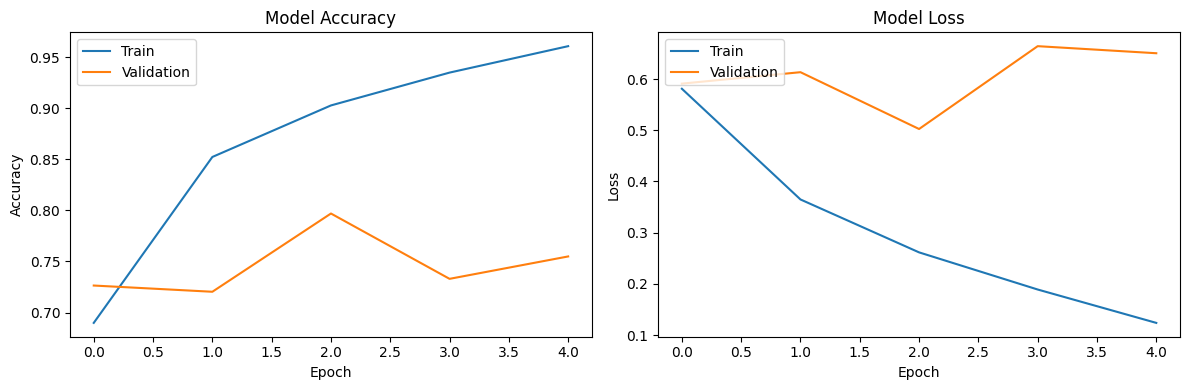

In [85]:
# RNN - sem pre processamento

# Tokeniza as reviews e transforma elas em sequências de inteiros
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data_balanced['review'])
X_train_RNN = tokenizer.texts_to_sequences(train_data_balanced['review'])
X_test_RNN = tokenizer.texts_to_sequences(test_data['review'])

# Pad the sequences so they all have the same length
X_train_RNN = pad_sequences(X_train_RNN, maxlen=100)
X_test_RNN = pad_sequences(X_test_RNN, maxlen=100)


# Cria o modelo RNN
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada de Embedding
model.add(SimpleRNN(32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada SimpleRNN
model.add(Dense(1, activation='sigmoid'))


# Compila o modelo
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Cria o callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Cria o callback de ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

# Treina o modelo e guarda o histórico
history = model.fit(X_train_RNN, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

# Avalia o modelo
_, accuracy = model.evaluate(X_test_RNN, y_test)
print(f'Accuracy: {accuracy}')

# Plota o gráfico de acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plota o gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



**RNN:** Resultados da modelação utilizando diferentes combinações de pré processamento e o léxico Emolex

In [219]:

# Inicializa o tokenizer
tokenizer = Tokenizer()

# Inicializa o modelo RNN
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada de Embedding
model.add(SimpleRNN(32))
model.add(Dropout(0.2))  # Adiciona Dropout após a camada SimpleRNN
model.add(Dense(1, activation='sigmoid'))

# Compila o modelo
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

# Cria o callback de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Cria o callback de ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.001)

results = []

for combo in tqdm(top_combinations, desc="Processing Combinations"):
    text_processing_method = combo[0]
    for method in text_processing_method:
        processed_train = X_train.apply(method)
        processed_test = X_test.apply(method)

    # Tokeniza as reviews e transforma elas em sequências de inteiros
    tokenizer.fit_on_texts(processed_train)
    X_train_seq = tokenizer.texts_to_sequences(processed_train)
    X_test_seq = tokenizer.texts_to_sequences(processed_test)

    # Pad the sequences so they all have the same length
    X_train_pad = pad_sequences(X_train_seq, maxlen=100)
    X_test_pad = pad_sequences(X_test_seq, maxlen=100)


    # Treina o modelo e guarda o histórico
    history = model.fit(X_train_pad, y_train, epochs=10, batch_size=128, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

    # Avalia o modelo
    _, accuracy = model.evaluate(X_test_pad, y_test)

    # Processa métricas do relatório de classificação
    report_metrics = {
        f"{label}_{metric}": report_dict[label][metric]
        for label in report_dict if label not in ['accuracy', 'macro avg', 'weighted avg']
        for metric in ['precision', 'recall', 'f1-score', 'support']
    }

    # Adiciona resultados à lista
    results.append({
        'combination': (", ".join([method.__name__ for method in text_processing_method])),
        'accuracy': accuracy,
         **report_metrics 
    })

# Converte resultados em DataFrame
results_rnn = pd.DataFrame(results)

# Guarda os resultados em um arquivo CSV
results_rnn.to_csv("results_rnn.csv", index=False)

Processing Combinations:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6445 - loss: 0.6248 - val_accuracy: 0.6492 - val_loss: 0.7231 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8421 - loss: 0.3846 - val_accuracy: 0.7002 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8837 - loss: 0.2971 - val_accuracy: 0.7131 - val_loss: 0.5985 - learning_rate: 0.0010
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9181 - loss: 0.2274 - val_accuracy: 0.7809 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9441 - loss: 0.1639 - val_accuracy: 0.7983 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9591 - loss: 0.1275 - val_accuracy: 0.7764 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9730 - loss: 0.

Processing Combinations:   5%|▌         | 1/20 [02:22<45:08, 142.54s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9802 - loss: 0.0662 - val_accuracy: 0.7466 - val_loss: 0.8817 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9823 - loss: 0.0558 - val_accuracy: 0.7782 - val_loss: 0.7800 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7885 - loss: 0.7415


Processing Combinations:  10%|█         | 2/20 [02:34<19:46, 65.92s/it] 

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9892 - loss: 0.0375 - val_accuracy: 0.7775 - val_loss: 0.8770 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9898 - loss: 0.0343 - val_accuracy: 0.7319 - val_loss: 0.9825 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7629 - loss: 0.9003


Processing Combinations:  15%|█▌        | 3/20 [03:24<16:33, 58.46s/it]

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9900 - loss: 0.0323 - val_accuracy: 0.7755 - val_loss: 0.8885 - learning_rate: 0.0010
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9935 - loss: 0.0249 - val_accuracy: 0.7987 - val_loss: 0.8603 - learning_rate: 0.0010
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7881 - loss: 0.9180


Processing Combinations:  20%|██        | 4/20 [03:44<11:31, 43.22s/it]

**LSTM (Long Short-Term Memory)**

LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) que é capaz de aprender e lembrar dependências de longo prazo em sequências de dados. 

As RNNs tradicionais têm dificuldade em aprender dependências de longo prazo devido ao chamado problema do desaparecimento do gradiente, onde as informações são perdidas ao longo do tempo. As LSTMs resolvem esse problema com uma estrutura de célula de memória especial que inclui portas para regular o fluxo de informações dentro e fora da célula.

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.6646 - loss: 0.6294 - val_accuracy: 0.8300 - val_loss: 0.3903
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8527 - loss: 0.3649 - val_accuracy: 0.8204 - val_loss: 0.4095
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8915 - loss: 0.2830 - val_accuracy: 0.8275 - val_loss: 0.4081
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9185 - loss: 0.2270 - val_accuracy: 0.8138 - val_loss: 0.4691
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9293 - loss: 0.1954 - val_accuracy: 0.8266 - val_loss: 0.4201
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9409 - loss: 0.1648 - val_accuracy: 0.8448 - val_loss: 0.4295
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9487 - loss: 0.1431 - val_accuracy: 0.8180 - val_loss: 0.4985
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9577 - loss: 0.1240 - val_acc

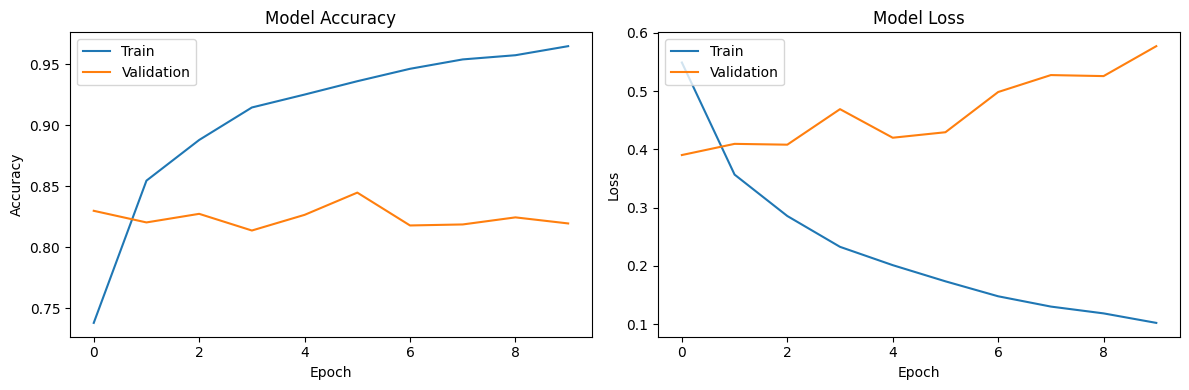

In [87]:
#LSTM (Long Short-Term Memory)

# Aplica a tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Transforma os textos em sequências de inteiros
max_length = 100  
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length)
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100 



# Modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.LSTM(10, dropout=0.2, recurrent_dropout=0.2), 
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compila o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o modelo
history = model.fit(X_train_seq, y_train, epochs=10, batch_size=128, validation_data=(X_test_seq, y_test))

# Avalia o modelo
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Previsões
y_pred = model.predict(X_test_seq)

# Converte probabilidades em classes
y_pred = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred)
print(report)

# Plota o gráfico de acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plota o gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.5820 - loss: 8.8905 - val_accuracy: 0.7009 - val_loss: 0.7209
Epoch 2/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.7577 - loss: 0.6550 - val_accuracy: 0.7191 - val_loss: 0.6730
Epoch 3/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.7992 - loss: 0.5892 - val_accuracy: 0.7232 - val_loss: 0.6530
Epoch 4/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.8217 - loss: 0.5376 - val_accuracy: 0.7257 - val_loss: 0.6411
Epoch 5/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8416 - loss: 0.5033 - val_accuracy: 0.7245 - val_loss: 0.6318
Epoch 6/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8561 - loss: 0.4749 - val_accuracy: 0.7286 - val_loss: 0.6339
Epoch 7/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8627 - loss: 1.0194 - val_accuracy: 0.7029 - val_loss: 0.6611
Epoch 8/20
173/173 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.8454 - loss: 0.

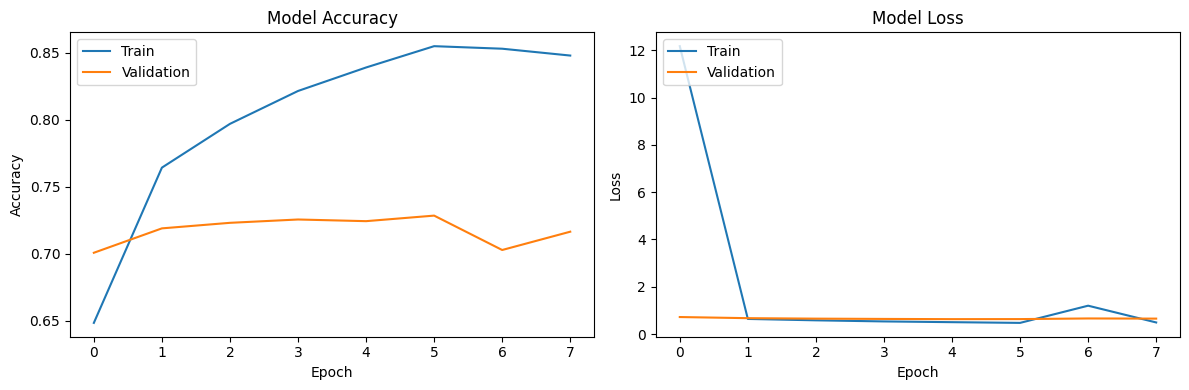

In [95]:


# Configuração do modelo
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
max_length = 100  
l2_lambda = 0.001  

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Bidirectional(GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(l2_lambda))),
    Dropout(0.5),
    GRU(16, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(l2_lambda)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test_seq, y_test),
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Previsões
y_pred = model.predict(X_test_seq)

# Converte probabilidades em classes
y_pred = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred)
print(report)

# Plota o gráfico de acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plota o gráfico de perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
# Predict and evaluate using classification report, etc.

## 4 Treino de um modelo (aprendizagem automática)

Nesta seção, abordaremos o processo de treinar um modelo de aprendizagem automática com o objetivo de melhorar o desempenho da classificação de dados. Seguiremos os seguintes passos:

## 4.1 Treinamento do Modelo

1. Selecione uma ferramenta de classificação adequada, como **scikit-learn**, TensorFlow, PyTorch, etc.
2. Prepare os dados de treino, garantindo que estão devidamente limpos e formatados para o processo de treinamento.
3. Configure e treine o modelo com o conjunto de dados de treino.

    - Várias configurações podem ser testadas:
        - Número de features.
        - Tratamento de maiúsculas e minúsculas.
        - Diferentes métodos de pré-processamento de texto (normalização, stemming, lematização, etc.).
        - Inclusão ou exclusão de informações de part-of-speech tagging.
        - Utilização de entidades nomeadas reconhecidas no texto.
        - Incorporação de embeddings pré-treinados, como GloVe.
        - Se houver desbalanceamento de classes usar 

## 4.2 Avaliação do Modelo

1. Aplique o modelo treinado ao conjunto de dados de teste.
2. Avalie o desempenho do modelo utilizando métricas adequadas, como precisão, recall, F1-score, etc.
3. Compare os resultados obtidos com os do modelo anterior para avaliar as melhorias.

## 4.3 Documentação e Experimentação

- Realize experimentos variados para entender o impacto de diferentes features e técnicas de pré-processamento.
- Documente cada experimento, incluindo a configuração usada e os resultados obtidos.
- Registre observações e conclusões relevantes a cada experimento.

## 4.4 Referências

- Alguns links que podem ajudar nesta tarefa 
    - https://www.kaggle.com/code/benroshan/sentiment-analysis-amazon-reviews#Extracting-Features-from-Cleaned-reviews
    - https://github.com/jesseqzhen/NLP_Sentiment_Analysis
    - https://www.kaggle.com/code/yacharki/binary-classification-amazon-reviews-84-lstm
    - https://www.kaggle.com/code/mammadabbasli/amazon-reviews-analysis-logisticregression

## 5 Utilização de transformadores para classificação

- https://medium.com/@minamehdinia213/fine-tunning-bert-model-for-amazon-product-review-and-deploying-it-into-hugging-face-model-hub-7d259839d556

A aplicação de modelos pré-treinados baseados em transformadores representa uma técnica poderosa no campo da aprendizagem automática, especialmente para tarefas de classificação de texto. O processo será dividido em duas etapas principais, conforme descrito a seguir:

## 5.1 Experimentação com Pipelines Pré-definidos

1. Escolha um ou mais modelos baseados em transformadores disponíveis, como BERT, GPT, Transformer-XL, etc.
2. Utilize pipelines pré-definidos oferecidos por bibliotecas como Hugging Face's Transformers para aplicar rapidamente o modelo aos seus dados.
   
    Exemplos de comandos de pipelines podem incluir:
    
    ```python
    from transformers import pipeline
    classifier = pipeline('text-classification', model='bert-base-uncased')
    ```
    
3. Avalie o desempenho desses modelos em seu conjunto de dados sem qualquer ajuste adicional, usando métricas padrão de classificação.

## 5.2 Fine-tuning de um Modelo Pré-treinado

1. Selecione um modelo pré-treinado apropriado para o seu conjunto de dados e a tarefa de classificação em questão.
2. Adapte o modelo ao seu conjunto de dados específico, o que é conhecido como fine-tuning. Isso envolve o treinamento do modelo em seu conjunto de dados, ajustando os pesos do modelo pré-treinado para melhor se adequar à sua tarefa específica.
3. Durante o fine-tuning, experimente com diferentes hiperparâmetros, como taxa de aprendizado, número de épocas, tamanho do lote e outros relevantes para o modelo escolhido.
   
    Exemplo de código para fine-tuning:
    
    ```python
    from transformers import BertForSequenceClassification, Trainer, TrainingArguments
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    training_args = TrainingArguments(output_dir='./results', num_train_epochs=3, ...)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
    
    trainer.train()
    ```
    
4. Após o fine-tuning, avalie novamente o modelo em seu conjunto de dados, usando as mesmas métricas de classificação para comparar o desempenho com o modelo antes do ajuste.

In [66]:

# Load do tokenizer e do modelo
model_name = "sbcBI/sentiment_analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
device = torch.device("mps")  # Apple's Metal Performance Shaders
model.to(device)



In [71]:
#Cria uma pipeline para análise de sentimentos
sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

test_data['results'] = test_data['review'].apply(lambda x: sentiment_analysis(x))

In [72]:
def best_sentiment(results):
    # mapeamento de labels
    label_mapping = {'LABEL_0': 0, 'LABEL_2': 1, 'LABEL_1': 'neutral'}
    
    # Ordena os resultados por score e pfica com o melhor resultado que não seja 'neutral'
    sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)
    best_result = next((r for r in sorted_results if label_mapping[r['label']] != 'neutral'), sorted_results[0])

    return label_mapping[best_result['label']]

#aplica a função best_sentiment para cada resultado
test_data['adjusted_results_sbcBI/sentiment_analysis'] = test_data['results'].apply(best_sentiment)

In [73]:
test_data['adjusted_results_sbcBI/sentiment_analysis'].value_counts()

adjusted_results_sbcBI/sentiment_analysis
negative    1212
positive    1205
Name: count, dtype: int64

In [74]:
report = classification_report(test_data['sentiment'], test_data['adjusted_results_sbcBI/sentiment_analysis'])
print(report)

              precision    recall  f1-score   support

    negative       0.56      0.91      0.69       741
    positive       0.94      0.68      0.79      1676

    accuracy                           0.75      2417
   macro avg       0.75      0.79      0.74      2417
weighted avg       0.82      0.75      0.76      2417



In [80]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [81]:
tqdm.pandas()


test_data['results_distilbert'] = test_data['review'].apply(lambda x: sentiment_analysis(x))


In [82]:
def best_sentiment(results):
    label_mapping = {'LABEL_0': 'negative', 'LABEL_2': 'positive', 'LABEL_1': 'neutral'}
    
    sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)
    best_result = next((r for r in sorted_results if label_mapping[r['label']] != 'neutral'), sorted_results[0])
    
    return label_mapping[best_result['label']]

test_data['adjusted_results'] = test_data['results_distilbert'].apply(best_sentiment)

[[{'label': 'LABEL_0', 'score': 0.3586060702800751}, {'label': 'LABEL_1', 'score': 0.31058454513549805}, {'label': 'LABEL_2', 'score': 0.3308093547821045}]]
[[{'label': 'LABEL_0', 'score': 0.3586060702800751}, {'label': 'LABEL_1', 'score': 0.31058454513549805}, {'label': 'LABEL_2', 'score': 0.3308093547821045}]]
[[{'label': 'LABEL_0', 'score': 0.34719711542129517}, {'label': 'LABEL_1', 'score': 0.3201386630535126}, {'label': 'LABEL_2', 'score': 0.33266422152519226}]]
[[{'label': 'LABEL_0', 'score': 0.34719711542129517}, {'label': 'LABEL_1', 'score': 0.3201386630535126}, {'label': 'LABEL_2', 'score': 0.33266422152519226}]]
[[{'label': 'LABEL_0', 'score': 0.346005916595459}, {'label': 'LABEL_1', 'score': 0.31545764207839966}, {'label': 'LABEL_2', 'score': 0.33853647112846375}]]
[[{'label': 'LABEL_0', 'score': 0.346005916595459}, {'label': 'LABEL_1', 'score': 0.31545764207839966}, {'label': 'LABEL_2', 'score': 0.33853647112846375}]]
[[{'label': 'LABEL_0', 'score': 0.35284850001335144}, {'

In [83]:
test_data['adjusted_results'].value_counts()

adjusted_results
negative    2259
positive     158
Name: count, dtype: int64

In [84]:
report = classification_report(test_data['sentiment'], test_data['adjusted_results'])
print(report)

              precision    recall  f1-score   support

    negative       0.32      0.98      0.49       741
    positive       0.92      0.09      0.16      1676

    accuracy                           0.36      2417
   macro avg       0.62      0.53      0.32      2417
weighted avg       0.74      0.36      0.26      2417



In [98]:

# Copia os dados de treino e mapeia sentimentos para valores numéricos
train_data_balanced_copy = train_data_balanced.copy()
train_data_balanced_copy['sentiment_converted'] = train_data_balanced_copy['sentiment'].map({'positive': 1, 'negative': 0})
train_data_balanced_copy = train_data_balanced_copy.drop(columns=['sentiment'])
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'sentiment_converted': 'labels'})
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'review': 'text'})

# Divide os dados em treino e validação
train_df, val_df = train_test_split(train_data_balanced_copy, test_size=0.1, random_state=42)

# Tokenizador do Transformers da Hugging Face
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    # Função para tokenizar os textos
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Converte DataFrame para Dataset para usar com a função `map` do Hugging Face
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Aplica a tokenização
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Define o formato dos datasets para PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Argumentos de treino
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=16, 
    warmup_steps=500,  
    weight_decay=0.01,  
    logging_dir='./logs',  
    logging_steps=50,  
    save_steps=200, 
    eval_steps=200,  
    evaluation_strategy="steps",  
    load_best_model_at_end=True,  
    metric_for_best_model='accuracy'  
)

# Inicializa o modelo
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Inicializa o Trainer especificando os nomes das labels
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()} 
)

# Inicia o treino
trainer.train()

# Avalia o modelo
results = trainer.evaluate()
print(results)

Map: 100%|██████████| 2214/2214 [00:00<00:00, 15885.78 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 50/2490 [00:16<11:06,  3.66it/s] 

{'loss': 0.69, 'grad_norm': 2.535264015197754, 'learning_rate': 5e-06, 'epoch': 0.02}


  4%|▍         | 100/2490 [00:30<10:36,  3.75it/s]

{'loss': 0.6632, 'grad_norm': 2.56221604347229, 'learning_rate': 1e-05, 'epoch': 0.04}


  6%|▌         | 150/2490 [00:43<10:37,  3.67it/s]

{'loss': 0.4532, 'grad_norm': 20.194103240966797, 'learning_rate': 1.5e-05, 'epoch': 0.06}


  8%|▊         | 200/2490 [00:57<10:18,  3.70it/s]

{'loss': 0.4038, 'grad_norm': 6.395805835723877, 'learning_rate': 2e-05, 'epoch': 0.08}


                                                  
  8%|▊         | 200/2490 [01:16<10:18,  3.70it/s]

{'eval_loss': 0.3722483515739441, 'eval_accuracy': 0.8414634146341463, 'eval_runtime': 19.181, 'eval_samples_per_second': 115.427, 'eval_steps_per_second': 7.247, 'epoch': 0.08}


 10%|█         | 250/2490 [01:33<10:42,  3.49it/s]  

{'loss': 0.3338, 'grad_norm': 3.398819923400879, 'learning_rate': 2.5e-05, 'epoch': 0.1}


 12%|█▏        | 300/2490 [01:48<11:15,  3.24it/s]

{'loss': 0.3799, 'grad_norm': 1.837843894958496, 'learning_rate': 3e-05, 'epoch': 0.12}


 14%|█▍        | 350/2490 [02:05<12:38,  2.82it/s]

{'loss': 0.4312, 'grad_norm': 3.2741870880126953, 'learning_rate': 3.5e-05, 'epoch': 0.14}


 16%|█▌        | 400/2490 [02:24<12:57,  2.69it/s]

{'loss': 0.4272, 'grad_norm': 11.693700790405273, 'learning_rate': 4e-05, 'epoch': 0.16}


                                                  
 16%|█▌        | 400/2490 [02:50<12:57,  2.69it/s]

{'eval_loss': 0.43853679299354553, 'eval_accuracy': 0.8035230352303523, 'eval_runtime': 25.9287, 'eval_samples_per_second': 85.388, 'eval_steps_per_second': 5.361, 'epoch': 0.16}


 18%|█▊        | 450/2490 [03:11<14:23,  2.36it/s]  

{'loss': 0.3724, 'grad_norm': 26.510906219482422, 'learning_rate': 4.5e-05, 'epoch': 0.18}


 20%|██        | 500/2490 [03:32<13:35,  2.44it/s]

{'loss': 0.3592, 'grad_norm': 3.6399357318878174, 'learning_rate': 5e-05, 'epoch': 0.2}


 22%|██▏       | 550/2490 [03:52<12:51,  2.52it/s]

{'loss': 0.4108, 'grad_norm': 27.7421875, 'learning_rate': 4.874371859296483e-05, 'epoch': 0.22}


 24%|██▍       | 600/2490 [04:12<11:42,  2.69it/s]

{'loss': 0.319, 'grad_norm': 6.51577615737915, 'learning_rate': 4.748743718592965e-05, 'epoch': 0.24}


                                                  
 24%|██▍       | 600/2490 [04:38<11:42,  2.69it/s]

{'eval_loss': 0.3583986461162567, 'eval_accuracy': 0.8631436314363143, 'eval_runtime': 26.406, 'eval_samples_per_second': 83.845, 'eval_steps_per_second': 5.264, 'epoch': 0.24}


 26%|██▌       | 650/2490 [04:59<13:01,  2.36it/s]  

{'loss': 0.3986, 'grad_norm': 5.271233081817627, 'learning_rate': 4.6231155778894475e-05, 'epoch': 0.26}


 28%|██▊       | 700/2490 [05:20<11:47,  2.53it/s]

{'loss': 0.3795, 'grad_norm': 4.1190924644470215, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.28}


 30%|███       | 750/2490 [05:39<10:42,  2.71it/s]

{'loss': 0.4359, 'grad_norm': 3.0043129920959473, 'learning_rate': 4.3718592964824124e-05, 'epoch': 0.3}


 32%|███▏      | 800/2490 [05:59<10:43,  2.63it/s]

{'loss': 0.319, 'grad_norm': 19.511573791503906, 'learning_rate': 4.246231155778895e-05, 'epoch': 0.32}


                                                  
 32%|███▏      | 800/2490 [06:25<10:43,  2.63it/s]

{'eval_loss': 0.39693278074264526, 'eval_accuracy': 0.8726287262872628, 'eval_runtime': 25.7839, 'eval_samples_per_second': 85.867, 'eval_steps_per_second': 5.391, 'epoch': 0.32}


 34%|███▍      | 850/2490 [06:46<11:05,  2.46it/s]  

{'loss': 0.3103, 'grad_norm': 22.325408935546875, 'learning_rate': 4.120603015075377e-05, 'epoch': 0.34}


 36%|███▌      | 900/2490 [07:07<10:32,  2.52it/s]

{'loss': 0.3931, 'grad_norm': 17.323564529418945, 'learning_rate': 3.9949748743718597e-05, 'epoch': 0.36}


 38%|███▊      | 950/2490 [07:28<10:00,  2.56it/s]

{'loss': 0.3153, 'grad_norm': 10.617576599121094, 'learning_rate': 3.869346733668342e-05, 'epoch': 0.38}


 40%|████      | 1000/2490 [07:47<09:23,  2.64it/s]

{'loss': 0.4101, 'grad_norm': 8.433290481567383, 'learning_rate': 3.7437185929648245e-05, 'epoch': 0.4}


                                                   
 40%|████      | 1000/2490 [08:14<09:23,  2.64it/s]

{'eval_loss': 0.3124939501285553, 'eval_accuracy': 0.8672086720867209, 'eval_runtime': 26.8231, 'eval_samples_per_second': 82.541, 'eval_steps_per_second': 5.182, 'epoch': 0.4}


 42%|████▏     | 1050/2490 [08:36<10:06,  2.37it/s]  

{'loss': 0.2994, 'grad_norm': 7.554142951965332, 'learning_rate': 3.618090452261307e-05, 'epoch': 0.42}


 44%|████▍     | 1100/2490 [08:58<09:43,  2.38it/s]

{'loss': 0.3069, 'grad_norm': 11.404810905456543, 'learning_rate': 3.4924623115577894e-05, 'epoch': 0.44}


 46%|████▌     | 1150/2490 [09:18<08:43,  2.56it/s]

{'loss': 0.3848, 'grad_norm': 2.5914669036865234, 'learning_rate': 3.366834170854272e-05, 'epoch': 0.46}


 48%|████▊     | 1200/2490 [09:39<08:28,  2.54it/s]

{'loss': 0.2865, 'grad_norm': 0.46062421798706055, 'learning_rate': 3.241206030150754e-05, 'epoch': 0.48}


                                                   
 48%|████▊     | 1200/2490 [10:05<08:28,  2.54it/s]

{'eval_loss': 0.3362441658973694, 'eval_accuracy': 0.8834688346883469, 'eval_runtime': 26.454, 'eval_samples_per_second': 83.692, 'eval_steps_per_second': 5.254, 'epoch': 0.48}


 50%|█████     | 1250/2490 [10:27<08:56,  2.31it/s]  

{'loss': 0.34, 'grad_norm': 0.9785895943641663, 'learning_rate': 3.1155778894472366e-05, 'epoch': 0.5}


 52%|█████▏    | 1300/2490 [10:47<08:02,  2.47it/s]

{'loss': 0.307, 'grad_norm': 9.20236873626709, 'learning_rate': 2.989949748743719e-05, 'epoch': 0.52}


 54%|█████▍    | 1350/2490 [11:08<07:05,  2.68it/s]

{'loss': 0.3888, 'grad_norm': 6.409286975860596, 'learning_rate': 2.8643216080402015e-05, 'epoch': 0.54}


 56%|█████▌    | 1400/2490 [11:26<06:36,  2.75it/s]

{'loss': 0.3579, 'grad_norm': 8.666890144348145, 'learning_rate': 2.738693467336684e-05, 'epoch': 0.56}


                                                   
 56%|█████▌    | 1400/2490 [11:51<06:36,  2.75it/s]

{'eval_loss': 0.4075186848640442, 'eval_accuracy': 0.8491418247515808, 'eval_runtime': 24.2374, 'eval_samples_per_second': 91.346, 'eval_steps_per_second': 5.735, 'epoch': 0.56}


 58%|█████▊    | 1450/2490 [12:10<06:20,  2.73it/s]  

{'loss': 0.2961, 'grad_norm': 10.824994087219238, 'learning_rate': 2.613065326633166e-05, 'epoch': 0.58}


 60%|██████    | 1500/2490 [12:28<05:57,  2.77it/s]

{'loss': 0.3564, 'grad_norm': 4.655509948730469, 'learning_rate': 2.4874371859296484e-05, 'epoch': 0.6}


 62%|██████▏   | 1550/2490 [12:46<05:23,  2.91it/s]

{'loss': 0.2016, 'grad_norm': 4.421453952789307, 'learning_rate': 2.361809045226131e-05, 'epoch': 0.62}


 64%|██████▍   | 1600/2490 [13:04<05:13,  2.84it/s]

{'loss': 0.2809, 'grad_norm': 7.659050464630127, 'learning_rate': 2.2361809045226133e-05, 'epoch': 0.64}


                                                   
 64%|██████▍   | 1600/2490 [13:28<05:13,  2.84it/s]

{'eval_loss': 0.3163509964942932, 'eval_accuracy': 0.8834688346883469, 'eval_runtime': 24.3041, 'eval_samples_per_second': 91.096, 'eval_steps_per_second': 5.719, 'epoch': 0.64}


 66%|██████▋   | 1650/2490 [13:47<05:30,  2.54it/s]  

{'loss': 0.2483, 'grad_norm': 3.5415732860565186, 'learning_rate': 2.1105527638190957e-05, 'epoch': 0.66}


 68%|██████▊   | 1700/2490 [14:06<04:50,  2.72it/s]

{'loss': 0.3492, 'grad_norm': 6.065814971923828, 'learning_rate': 1.984924623115578e-05, 'epoch': 0.68}


 70%|███████   | 1750/2490 [14:25<04:27,  2.77it/s]

{'loss': 0.2842, 'grad_norm': 1.088669776916504, 'learning_rate': 1.8592964824120602e-05, 'epoch': 0.7}


 72%|███████▏  | 1800/2490 [14:43<04:05,  2.82it/s]

{'loss': 0.3927, 'grad_norm': 9.103887557983398, 'learning_rate': 1.7336683417085427e-05, 'epoch': 0.72}


                                                   
 72%|███████▏  | 1800/2490 [15:08<04:05,  2.82it/s]

{'eval_loss': 0.27606549859046936, 'eval_accuracy': 0.8947606142728094, 'eval_runtime': 24.7399, 'eval_samples_per_second': 89.491, 'eval_steps_per_second': 5.618, 'epoch': 0.72}


 74%|███████▍  | 1850/2490 [15:27<03:57,  2.70it/s]  

{'loss': 0.2944, 'grad_norm': 7.175522327423096, 'learning_rate': 1.608040201005025e-05, 'epoch': 0.74}


 76%|███████▋  | 1900/2490 [15:47<04:44,  2.08it/s]

{'loss': 0.3204, 'grad_norm': 1.2067551612854004, 'learning_rate': 1.4824120603015077e-05, 'epoch': 0.76}


 78%|███████▊  | 1950/2490 [16:08<03:17,  2.73it/s]

{'loss': 0.3113, 'grad_norm': 5.329477787017822, 'learning_rate': 1.3567839195979901e-05, 'epoch': 0.78}


 80%|████████  | 2000/2490 [16:26<02:58,  2.74it/s]

{'loss': 0.3125, 'grad_norm': 10.296854972839355, 'learning_rate': 1.2311557788944725e-05, 'epoch': 0.8}


                                                   
 80%|████████  | 2000/2490 [16:50<02:58,  2.74it/s]

{'eval_loss': 0.291610985994339, 'eval_accuracy': 0.9010840108401084, 'eval_runtime': 24.0101, 'eval_samples_per_second': 92.211, 'eval_steps_per_second': 5.789, 'epoch': 0.8}


 82%|████████▏ | 2050/2490 [17:10<02:39,  2.75it/s]  

{'loss': 0.3197, 'grad_norm': 7.6621599197387695, 'learning_rate': 1.105527638190955e-05, 'epoch': 0.82}


 84%|████████▍ | 2100/2490 [17:29<02:22,  2.73it/s]

{'loss': 0.2605, 'grad_norm': 9.448904991149902, 'learning_rate': 9.798994974874372e-06, 'epoch': 0.84}


 86%|████████▋ | 2150/2490 [17:47<02:09,  2.63it/s]

{'loss': 0.2719, 'grad_norm': 13.0108060836792, 'learning_rate': 8.542713567839196e-06, 'epoch': 0.86}


 88%|████████▊ | 2200/2490 [18:05<01:44,  2.77it/s]

{'loss': 0.2678, 'grad_norm': 13.065155029296875, 'learning_rate': 7.28643216080402e-06, 'epoch': 0.88}


                                                   
 88%|████████▊ | 2200/2490 [18:30<01:44,  2.77it/s]

{'eval_loss': 0.2976367473602295, 'eval_accuracy': 0.8970189701897019, 'eval_runtime': 24.6058, 'eval_samples_per_second': 89.979, 'eval_steps_per_second': 5.649, 'epoch': 0.88}


 90%|█████████ | 2250/2490 [18:50<01:41,  2.37it/s]

{'loss': 0.338, 'grad_norm': 13.528477668762207, 'learning_rate': 6.030150753768844e-06, 'epoch': 0.9}


 92%|█████████▏| 2300/2490 [19:09<01:10,  2.70it/s]

{'loss': 0.3228, 'grad_norm': 4.187526226043701, 'learning_rate': 4.773869346733668e-06, 'epoch': 0.92}


 94%|█████████▍| 2350/2490 [19:27<00:49,  2.82it/s]

{'loss': 0.3531, 'grad_norm': 5.326048374176025, 'learning_rate': 3.5175879396984926e-06, 'epoch': 0.94}


 96%|█████████▋| 2400/2490 [19:46<00:36,  2.44it/s]

{'loss': 0.2097, 'grad_norm': 10.9658842086792, 'learning_rate': 2.261306532663317e-06, 'epoch': 0.96}


                                                   
 96%|█████████▋| 2400/2490 [20:13<00:36,  2.44it/s]

{'eval_loss': 0.2787339985370636, 'eval_accuracy': 0.8988256549232159, 'eval_runtime': 27.3613, 'eval_samples_per_second': 80.917, 'eval_steps_per_second': 5.08, 'epoch': 0.96}


 98%|█████████▊| 2450/2490 [20:33<00:15,  2.63it/s]

{'loss': 0.2147, 'grad_norm': 17.386863708496094, 'learning_rate': 1.0050251256281407e-06, 'epoch': 0.98}


100%|██████████| 2490/2490 [20:49<00:00,  1.99it/s]


{'train_runtime': 1249.7465, 'train_samples_per_second': 15.939, 'train_steps_per_second': 1.992, 'train_loss': 0.3493456043871531, 'epoch': 1.0}


100%|██████████| 139/139 [00:26<00:00,  5.20it/s]

{'eval_loss': 0.291610985994339, 'eval_accuracy': 0.9010840108401084, 'eval_runtime': 26.8627, 'eval_samples_per_second': 82.419, 'eval_steps_per_second': 5.174, 'epoch': 1.0}


In [99]:

# Carrega o tokenizador
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Prepara os dados de teste
test_data_copy = test_data.copy()
test_data_copy = test_data_copy[['review', 'sentiment']]
test_data_copy.rename(columns={'sentiment': 'labels', 'review': 'text'}, inplace=True)
test_dataset = Dataset.from_pandas(test_data_copy)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

predictions = trainer.predict(test_dataset)

# Processa as previsões
probabilities = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)
final_predictions = np.argmax(probabilities, axis=1)
true_labels = predictions.label_ids

# Relatório de classificação
report = classification_report(true_labels, final_predictions, target_names=['Negative', 'Positive'])
print(report)

100%|██████████| 152/152 [00:19<00:00,  7.66it/s]

              precision    recall  f1-score   support

    Negative       0.75      0.95      0.84       741
    Positive       0.98      0.86      0.92      1676

    accuracy                           0.89      2417
   macro avg       0.86      0.91      0.88      2417
weighted avg       0.91      0.89      0.89      2417



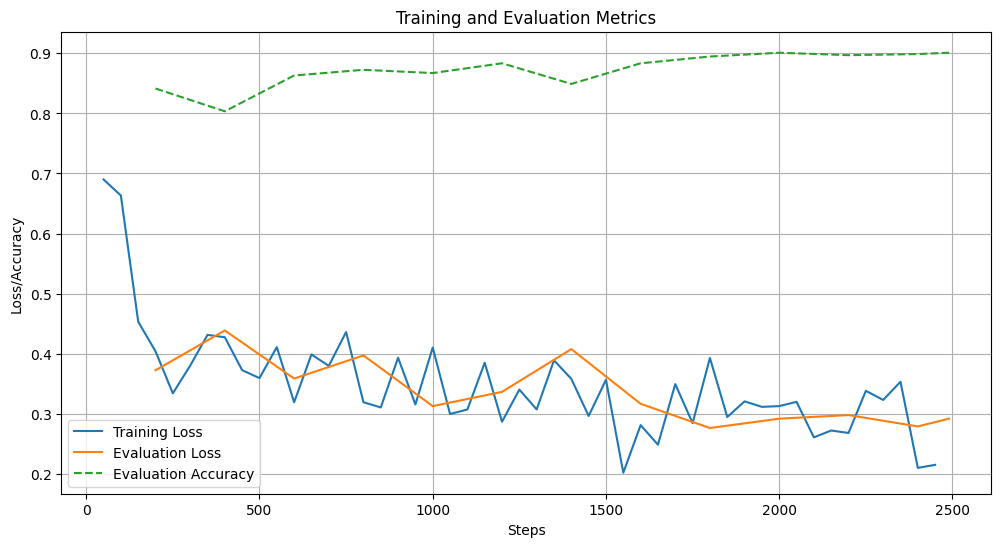

In [100]:
#Log das métricas de treino
log_history = trainer.state.log_history

# Extração de métricas
training_logs = [x for x in log_history if 'loss' in x and 'eval_loss' not in x]
evaluation_logs = [x for x in log_history if 'eval_loss' in x]

# Plotting das métricas
plt.figure(figsize=(12, 6))

# Loss de treino
train_steps = [x['step'] for x in training_logs]
train_loss = [x['loss'] for x in training_logs]
plt.plot(train_steps, train_loss, label='Training Loss')

# Loss e accuracy de validação
eval_steps = [x['step'] for x in evaluation_logs]
eval_loss = [x['eval_loss'] for x in evaluation_logs]
eval_accuracy = [x['eval_accuracy'] for x in evaluation_logs]
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Loss/Accuracy')
plt.title('Training and Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [102]:
model_distilbert = AutoModelForSequenceClassification.from_pretrained('./saved_model')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [103]:
def test_dataset_loaded_from_memory(sample_text):
    
    sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    # Move o modelo e os inputs para a GPU
    model_distilbert.to(training_args.device)
    sample_inputs.to(training_args.device)

    predictions = model(**sample_inputs)
    predicted_class = predictions.logits.argmax(-1).item()

    if predicted_class == 1:
        return 1
    else:
        return 0
    

tqdm.pandas()

test_data_copy['labels_predicted'] = test_data_copy['text'].progress_apply(lambda x: test_dataset_loaded_from_memory(x))

print(test_data_copy['labels_predicted'].value_counts())

print(classification_report(test_data_copy['labels'], test_data_copy['labels_predicted']))


100%|██████████| 2417/2417 [02:10<00:00, 18.58it/s]

labels_predicted
1    1512
0     905
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       741
           1       0.98      0.88      0.93      1676

    accuracy                           0.90      2417
   macro avg       0.88      0.92      0.89      2417
weighted avg       0.92      0.90      0.91      2417



In [101]:
# Copia os dados de treino, mapeia sentimentos para valores numéricos e aplica pré-processamento
train_data_balanced_copy = train_data_balanced.copy()
train_data_balanced_copy['sentiment_converted'] = train_data_balanced_copy['sentiment'].map({'positive': 1, 'negative': 0})
train_data_balanced_copy = train_data_balanced_copy.drop(columns=['sentiment'])
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'sentiment_converted': 'labels'})
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'review': 'text'})
train_data_balanced_copy['text'] = train_data_balanced_copy['text'] = train_data_balanced_copy["text"].apply(lambda review: lemmatize(remove_stopwords(expand_contractions(clean(review)))))
train_data_balanced_copy['text'] = train_data_balanced_copy['text'].apply(lambda x: ' '.join(x))


train_df, val_df = train_test_split(train_data_balanced_copy, test_size=0.1, random_state=42)

# Tokenizer from the Hugging Face Transformers
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert DataFrame to Dataset to use with Hugging Face's `map` function
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize the Trainer with label names specified
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}  # Example metric function
)

# Start training
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

Map: 100%|██████████| 2214/2214 [00:00<00:00, 21160.67 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 50/2490 [00:14<11:05,  3.66it/s]

{'loss': 0.6905, 'grad_norm': 2.529536008834839, 'learning_rate': 5e-06, 'epoch': 0.02}


  4%|▍         | 100/2490 [00:28<10:37,  3.75it/s]

{'loss': 0.6777, 'grad_norm': 2.0647056102752686, 'learning_rate': 1e-05, 'epoch': 0.04}


  6%|▌         | 150/2490 [00:41<10:50,  3.60it/s]

{'loss': 0.6265, 'grad_norm': 6.2733473777771, 'learning_rate': 1.5e-05, 'epoch': 0.06}


  8%|▊         | 200/2490 [00:55<10:14,  3.73it/s]

{'loss': 0.5974, 'grad_norm': 6.664205074310303, 'learning_rate': 2e-05, 'epoch': 0.08}



  8%|▊         | 200/2490 [01:13<10:14,  3.73it/s]

{'eval_loss': 0.4853021204471588, 'eval_accuracy': 0.7926829268292683, 'eval_runtime': 18.0515, 'eval_samples_per_second': 122.649, 'eval_steps_per_second': 7.7, 'epoch': 0.08}


 10%|█         | 250/2490 [01:27<10:03,  3.71it/s]  

{'loss': 0.4292, 'grad_norm': 14.21162223815918, 'learning_rate': 2.5e-05, 'epoch': 0.1}


 12%|█▏        | 300/2490 [01:41<09:54,  3.68it/s]

{'loss': 0.501, 'grad_norm': 10.271661758422852, 'learning_rate': 3e-05, 'epoch': 0.12}


 14%|█▍        | 350/2490 [01:55<09:35,  3.72it/s]

{'loss': 0.5197, 'grad_norm': 11.016067504882812, 'learning_rate': 3.5e-05, 'epoch': 0.14}


 16%|█▌        | 400/2490 [02:08<09:22,  3.71it/s]

{'loss': 0.5097, 'grad_norm': 4.582715034484863, 'learning_rate': 4e-05, 'epoch': 0.16}



 16%|█▌        | 400/2490 [02:26<09:22,  3.71it/s]

{'eval_loss': 0.5396762490272522, 'eval_accuracy': 0.7809394760614273, 'eval_runtime': 17.8749, 'eval_samples_per_second': 123.861, 'eval_steps_per_second': 7.776, 'epoch': 0.16}


 18%|█▊        | 450/2490 [02:41<09:08,  3.72it/s]  

{'loss': 0.5052, 'grad_norm': 11.00912094116211, 'learning_rate': 4.5e-05, 'epoch': 0.18}


 20%|██        | 500/2490 [05:12<11:21,  2.92it/s]   

{'loss': 0.4513, 'grad_norm': 3.5076591968536377, 'learning_rate': 5e-05, 'epoch': 0.2}


 22%|██▏       | 550/2490 [14:22<08:55,  3.62it/s]    

{'loss': 0.5138, 'grad_norm': 4.023507595062256, 'learning_rate': 4.874371859296483e-05, 'epoch': 0.22}


 24%|██▍       | 600/2490 [26:15<29:10:40, 55.58s/it] 

{'loss': 0.4266, 'grad_norm': 2.580045223236084, 'learning_rate': 4.748743718592965e-05, 'epoch': 0.24}



 24%|██▍       | 600/2490 [26:34<29:10:40, 55.58s/it]

{'eval_loss': 0.5799745321273804, 'eval_accuracy': 0.7533875338753387, 'eval_runtime': 19.0804, 'eval_samples_per_second': 116.035, 'eval_steps_per_second': 7.285, 'epoch': 0.24}


 26%|██▌       | 650/2490 [26:49<08:15,  3.71it/s]   

{'loss': 0.5741, 'grad_norm': 11.862712860107422, 'learning_rate': 4.6231155778894475e-05, 'epoch': 0.26}


 28%|██▊       | 700/2490 [27:03<08:03,  3.70it/s]

{'loss': 0.4758, 'grad_norm': 3.836987018585205, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.28}


 30%|███       | 750/2490 [27:17<07:56,  3.65it/s]

{'loss': 0.4483, 'grad_norm': 7.13626766204834, 'learning_rate': 4.3718592964824124e-05, 'epoch': 0.3}


 32%|███▏      | 800/2490 [27:31<07:38,  3.68it/s]

{'loss': 0.4418, 'grad_norm': 2.5600829124450684, 'learning_rate': 4.246231155778895e-05, 'epoch': 0.32}



 32%|███▏      | 800/2490 [27:49<07:38,  3.68it/s]

{'eval_loss': 0.4429713189601898, 'eval_accuracy': 0.8057813911472448, 'eval_runtime': 17.9523, 'eval_samples_per_second': 123.327, 'eval_steps_per_second': 7.743, 'epoch': 0.32}


 34%|███▍      | 850/2490 [28:03<07:21,  3.72it/s]  

{'loss': 0.4055, 'grad_norm': 10.595307350158691, 'learning_rate': 4.120603015075377e-05, 'epoch': 0.34}


 36%|███▌      | 900/2490 [28:17<07:07,  3.72it/s]

{'loss': 0.3961, 'grad_norm': 9.207784652709961, 'learning_rate': 3.9949748743718597e-05, 'epoch': 0.36}


 38%|███▊      | 950/2490 [28:30<07:12,  3.56it/s]

{'loss': 0.3948, 'grad_norm': 6.995338439941406, 'learning_rate': 3.869346733668342e-05, 'epoch': 0.38}


 40%|████      | 1000/2490 [28:44<06:39,  3.73it/s]

{'loss': 0.4358, 'grad_norm': 5.006596565246582, 'learning_rate': 3.7437185929648245e-05, 'epoch': 0.4}



 40%|████      | 1000/2490 [29:02<06:39,  3.73it/s]

{'eval_loss': 0.46287843585014343, 'eval_accuracy': 0.7822944896115628, 'eval_runtime': 18.0004, 'eval_samples_per_second': 122.997, 'eval_steps_per_second': 7.722, 'epoch': 0.4}


 42%|████▏     | 1050/2490 [29:16<06:31,  3.68it/s]  

{'loss': 0.4119, 'grad_norm': 1.9835381507873535, 'learning_rate': 3.618090452261307e-05, 'epoch': 0.42}


 44%|████▍     | 1100/2490 [29:30<06:13,  3.72it/s]

{'loss': 0.4037, 'grad_norm': 1.4253753423690796, 'learning_rate': 3.4924623115577894e-05, 'epoch': 0.44}


 46%|████▌     | 1150/2490 [29:43<05:59,  3.73it/s]

{'loss': 0.4613, 'grad_norm': 3.2117395401000977, 'learning_rate': 3.366834170854272e-05, 'epoch': 0.46}


 48%|████▊     | 1200/2490 [29:57<05:46,  3.72it/s]

{'loss': 0.3358, 'grad_norm': 11.234291076660156, 'learning_rate': 3.241206030150754e-05, 'epoch': 0.48}



 48%|████▊     | 1200/2490 [30:15<05:46,  3.72it/s]

{'eval_loss': 0.4278886616230011, 'eval_accuracy': 0.8301716350496838, 'eval_runtime': 17.9928, 'eval_samples_per_second': 123.049, 'eval_steps_per_second': 7.725, 'epoch': 0.48}


 50%|█████     | 1250/2490 [30:29<05:33,  3.72it/s]  

{'loss': 0.4052, 'grad_norm': 2.054733991622925, 'learning_rate': 3.1155778894472366e-05, 'epoch': 0.5}


 52%|█████▏    | 1300/2490 [30:43<05:19,  3.72it/s]

{'loss': 0.4004, 'grad_norm': 3.8373138904571533, 'learning_rate': 2.989949748743719e-05, 'epoch': 0.52}


 54%|█████▍    | 1350/2490 [30:56<05:05,  3.73it/s]

{'loss': 0.404, 'grad_norm': 3.8663346767425537, 'learning_rate': 2.8643216080402015e-05, 'epoch': 0.54}


 56%|█████▌    | 1400/2490 [31:10<04:56,  3.67it/s]

{'loss': 0.4126, 'grad_norm': 4.103246688842773, 'learning_rate': 2.738693467336684e-05, 'epoch': 0.56}



 56%|█████▌    | 1400/2490 [31:28<04:56,  3.67it/s]

{'eval_loss': 0.3972121775150299, 'eval_accuracy': 0.8252032520325203, 'eval_runtime': 17.9916, 'eval_samples_per_second': 123.058, 'eval_steps_per_second': 7.726, 'epoch': 0.56}


 58%|█████▊    | 1450/2490 [31:42<04:38,  3.73it/s]  

{'loss': 0.346, 'grad_norm': 5.954625606536865, 'learning_rate': 2.613065326633166e-05, 'epoch': 0.58}


 60%|██████    | 1500/2490 [31:56<04:25,  3.73it/s]

{'loss': 0.3779, 'grad_norm': 0.9470037221908569, 'learning_rate': 2.4874371859296484e-05, 'epoch': 0.6}


 62%|██████▏   | 1550/2490 [32:09<04:28,  3.50it/s]

{'loss': 0.2965, 'grad_norm': 3.88725209236145, 'learning_rate': 2.361809045226131e-05, 'epoch': 0.62}


 64%|██████▍   | 1600/2490 [32:23<04:00,  3.70it/s]

{'loss': 0.4032, 'grad_norm': 1.0555007457733154, 'learning_rate': 2.2361809045226133e-05, 'epoch': 0.64}



 64%|██████▍   | 1600/2490 [32:41<04:00,  3.70it/s]

{'eval_loss': 0.36014002561569214, 'eval_accuracy': 0.8473351400180669, 'eval_runtime': 17.9618, 'eval_samples_per_second': 123.262, 'eval_steps_per_second': 7.739, 'epoch': 0.64}


 66%|██████▋   | 1650/2490 [32:55<03:45,  3.73it/s]  

{'loss': 0.3438, 'grad_norm': 9.307290077209473, 'learning_rate': 2.1105527638190957e-05, 'epoch': 0.66}


 68%|██████▊   | 1700/2490 [33:09<03:36,  3.64it/s]

{'loss': 0.4332, 'grad_norm': 5.106156826019287, 'learning_rate': 1.984924623115578e-05, 'epoch': 0.68}


 70%|███████   | 1750/2490 [33:22<03:18,  3.73it/s]

{'loss': 0.3798, 'grad_norm': 7.608436584472656, 'learning_rate': 1.8592964824120602e-05, 'epoch': 0.7}


 72%|███████▏  | 1800/2490 [33:36<03:04,  3.74it/s]

{'loss': 0.3976, 'grad_norm': 3.4196324348449707, 'learning_rate': 1.7336683417085427e-05, 'epoch': 0.72}



 72%|███████▏  | 1800/2490 [33:54<03:04,  3.74it/s]

{'eval_loss': 0.3591669499874115, 'eval_accuracy': 0.8473351400180669, 'eval_runtime': 17.9766, 'eval_samples_per_second': 123.16, 'eval_steps_per_second': 7.732, 'epoch': 0.72}


 74%|███████▍  | 1850/2490 [34:08<02:52,  3.71it/s]  

{'loss': 0.3623, 'grad_norm': 3.460914134979248, 'learning_rate': 1.608040201005025e-05, 'epoch': 0.74}


 76%|███████▋  | 1900/2490 [34:22<02:40,  3.67it/s]

{'loss': 0.3648, 'grad_norm': 5.503217697143555, 'learning_rate': 1.4824120603015077e-05, 'epoch': 0.76}


 78%|███████▊  | 1950/2490 [34:36<02:33,  3.53it/s]

{'loss': 0.3558, 'grad_norm': 6.046627998352051, 'learning_rate': 1.3567839195979901e-05, 'epoch': 0.78}


 80%|████████  | 2000/2490 [34:51<02:30,  3.27it/s]

{'loss': 0.366, 'grad_norm': 5.626455783843994, 'learning_rate': 1.2311557788944725e-05, 'epoch': 0.8}



 80%|████████  | 2000/2490 [35:12<02:30,  3.27it/s]

{'eval_loss': 0.38230112195014954, 'eval_accuracy': 0.8504968383017163, 'eval_runtime': 20.7694, 'eval_samples_per_second': 106.599, 'eval_steps_per_second': 6.693, 'epoch': 0.8}


 82%|████████▏ | 2050/2490 [35:28<02:15,  3.24it/s]

{'loss': 0.4102, 'grad_norm': 7.312149524688721, 'learning_rate': 1.105527638190955e-05, 'epoch': 0.82}


 84%|████████▍ | 2100/2490 [35:44<01:58,  3.28it/s]

{'loss': 0.3711, 'grad_norm': 6.65657901763916, 'learning_rate': 9.798994974874372e-06, 'epoch': 0.84}


 86%|████████▋ | 2150/2490 [35:59<01:42,  3.32it/s]

{'loss': 0.3272, 'grad_norm': 6.68855619430542, 'learning_rate': 8.542713567839196e-06, 'epoch': 0.86}


 88%|████████▊ | 2200/2490 [36:14<01:27,  3.32it/s]

{'loss': 0.3289, 'grad_norm': 6.7072343826293945, 'learning_rate': 7.28643216080402e-06, 'epoch': 0.88}



 88%|████████▊ | 2200/2490 [36:35<01:27,  3.32it/s]

{'eval_loss': 0.3956999182701111, 'eval_accuracy': 0.8441734417344173, 'eval_runtime': 20.4477, 'eval_samples_per_second': 108.276, 'eval_steps_per_second': 6.798, 'epoch': 0.88}


 90%|█████████ | 2250/2490 [36:51<01:13,  3.25it/s]

{'loss': 0.374, 'grad_norm': 1.0455825328826904, 'learning_rate': 6.030150753768844e-06, 'epoch': 0.9}


 92%|█████████▏| 2300/2490 [37:06<00:58,  3.25it/s]

{'loss': 0.4358, 'grad_norm': 4.759385108947754, 'learning_rate': 4.773869346733668e-06, 'epoch': 0.92}


 94%|█████████▍| 2350/2490 [37:22<00:42,  3.31it/s]

{'loss': 0.3435, 'grad_norm': 5.097073078155518, 'learning_rate': 3.5175879396984926e-06, 'epoch': 0.94}


 96%|█████████▋| 2400/2490 [37:37<00:26,  3.34it/s]

{'loss': 0.2878, 'grad_norm': 5.62268590927124, 'learning_rate': 2.261306532663317e-06, 'epoch': 0.96}



 96%|█████████▋| 2400/2490 [37:58<00:26,  3.34it/s]

{'eval_loss': 0.3640303909778595, 'eval_accuracy': 0.8473351400180669, 'eval_runtime': 20.4227, 'eval_samples_per_second': 108.409, 'eval_steps_per_second': 6.806, 'epoch': 0.96}


 98%|█████████▊| 2450/2490 [38:14<00:13,  3.07it/s]

{'loss': 0.3313, 'grad_norm': 4.137351036071777, 'learning_rate': 1.0050251256281407e-06, 'epoch': 0.98}


100%|██████████| 2490/2490 [38:28<00:00,  1.08it/s]


{'train_runtime': 2308.3391, 'train_samples_per_second': 8.63, 'train_steps_per_second': 1.079, 'train_loss': 0.4260031374582804, 'epoch': 1.0}


100%|██████████| 139/139 [00:20<00:00,  6.66it/s]

{'eval_loss': 0.38230112195014954, 'eval_accuracy': 0.8504968383017163, 'eval_runtime': 21.02, 'eval_samples_per_second': 105.328, 'eval_steps_per_second': 6.613, 'epoch': 1.0}


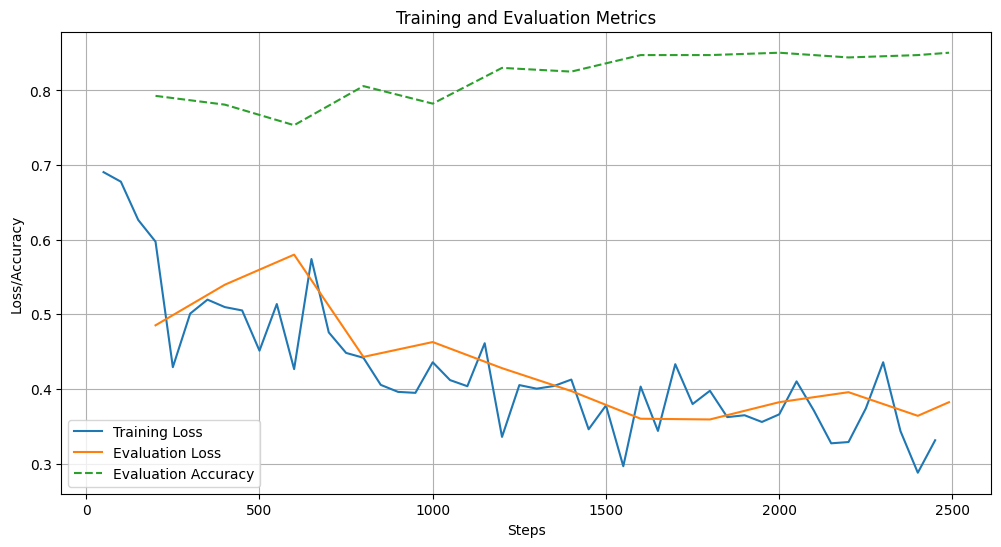

In [104]:

log_history = trainer.state.log_history

training_logs = [x for x in log_history if 'loss' in x and 'eval_loss' not in x]
evaluation_logs = [x for x in log_history if 'eval_loss' in x]

plt.figure(figsize=(12, 6))

train_steps = [x['step'] for x in training_logs]
train_loss = [x['loss'] for x in training_logs]
plt.plot(train_steps, train_loss, label='Training Loss')

eval_steps = [x['step'] for x in evaluation_logs]
eval_loss = [x['eval_loss'] for x in evaluation_logs]
eval_accuracy = [x['eval_accuracy'] for x in evaluation_logs]
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy', linestyle='--')

plt.xlabel('Steps')
plt.ylabel('Loss/Accuracy')
plt.title('Training and Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

test_data_copy = test_data.copy()
test_data_copy =                                                                                                                                                                                                                                                                                            test_data_copy[['review', 'sentiment']]
test_data_copy.rename(columns={'sentiment': 'labels'}, inplace=True)
test_data_copy.rename(columns={'review': 'text'}, inplace=True)
test_data_copy = test_data_copy[['text', 'labels']]
test_dataset = Dataset.from_pandas(test_data_copy)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

predictions = trainer.predict(test_dataset)

probabilities = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)
final_predictions = np.argmax(probabilities, axis=1)
true_labels = predictions.label_ids

report = classification_report(true_labels, final_predictions, target_names=['Negative', 'Positive'])
print(report)

100%|██████████| 152/152 [00:19<00:00,  7.81it/s]


              precision    recall  f1-score   support

    Negative       0.67      0.91      0.77       741
    Positive       0.95      0.81      0.87      1676

    accuracy                           0.84      2417
   macro avg       0.81      0.86      0.82      2417
weighted avg       0.87      0.84      0.84      2417



In [110]:
model_path = "./saved_model_processed"
trainer.save_model(model_path)

In [112]:
model_distilbert_processed = AutoModelForSequenceClassification.from_pretrained('./saved_model_processed')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


In [116]:
def test_dataset_loaded_from_memory(sample_text):
    
    sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    # Move inputs to device (if GPU available)
    model_distilbert_processed.to(training_args.device)
    sample_inputs.to(training_args.device)

    # Make prediction
    predictions = model(**sample_inputs)
    predicted_class = predictions.logits.argmax(-1).item()

    if predicted_class == 1:
        return 1
    else:
        return 0
    


test_data_copy['labels_predicted'] = test_data_copy['text'].progress_apply(lambda x: test_dataset_loaded_from_memory(x))

print(test_data_copy['labels_predicted'].value_counts())

print(classification_report(test_data_copy['labels'], test_data_copy['labels_predicted']))


Negative sentiment


---------------------------------------------------------------------------

In [118]:
model_name = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
device = torch.device("mps")  # Apple's Metal Performance Shaders
model.to(device)
sentiment_analysis = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
test_data['results_xl_transformers'] = test_data['review'].apply(lambda x: sentiment_analysis(x))

In [ ]:
test_data['results_xl_transformers'] 

In [120]:
def best_sentiment(results):
    label_mapping = {'LABEL_0': 'negative', 'LABEL_2': 'positive', 'LABEL_1': 'neutral'}
    
    sorted_results = sorted(results[0], key=lambda x: x['score'], reverse=True)
    best_result = next((r for r in sorted_results if label_mapping[r['label']] != 'neutral'), sorted_results[0])
    
    return label_mapping[best_result['label']]

test_data['adjusted_results'] = test_data['results_xl_transformers'].apply(best_sentiment)

[{'label': 'LABEL_0', 'score': 0.5283176898956299}, {'label': 'LABEL_1', 'score': 0.47168228030204773}]
[{'label': 'LABEL_0', 'score': 0.480172336101532}, {'label': 'LABEL_1', 'score': 0.519827663898468}]
[{'label': 'LABEL_0', 'score': 0.540547251701355}, {'label': 'LABEL_1', 'score': 0.459452748298645}]
[{'label': 'LABEL_0', 'score': 0.5136978030204773}, {'label': 'LABEL_1', 'score': 0.4863021671772003}]
[{'label': 'LABEL_0', 'score': 0.45402947068214417}, {'label': 'LABEL_1', 'score': 0.5459705591201782}]
[{'label': 'LABEL_0', 'score': 0.526088297367096}, {'label': 'LABEL_1', 'score': 0.47391170263290405}]
[{'label': 'LABEL_0', 'score': 0.48958897590637207}, {'label': 'LABEL_1', 'score': 0.5104110240936279}]
[{'label': 'LABEL_0', 'score': 0.5813609957695007}, {'label': 'LABEL_1', 'score': 0.41863900423049927}]
[{'label': 'LABEL_0', 'score': 0.5167867541313171}, {'label': 'LABEL_1', 'score': 0.4832132160663605}]
[{'label': 'LABEL_0', 'score': 0.4836106598377228}, {'label': 'LABEL_1', 

In [121]:
test_data['adjusted_results'].value_counts()

adjusted_results
negative    2417
Name: count, dtype: int64

In [122]:
report = classification_report(test_data['sentiment'], test_data['adjusted_results'], target_names=['Negative', 'Positive'])
print(report)

              precision    recall  f1-score   support

    Negative       0.31      1.00      0.47       741
    Positive       0.00      0.00      0.00      1676

    accuracy                           0.31      2417
   macro avg       0.15      0.50      0.23      2417
weighted avg       0.09      0.31      0.14      2417



In [4]:
# Load dos dados de treino e mapeia sentimentos para valores numéricos
train_data_balanced_copy = train_data_balanced.copy()
train_data_balanced_copy['sentiment_converted'] = train_data_balanced_copy['sentiment'].map({'positive': 1, 'negative': 0})
train_data_balanced_copy = train_data_balanced_copy.drop(columns=['sentiment'])
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'sentiment_converted': 'labels'})
train_data_balanced_copy = train_data_balanced_copy.rename(columns={'review': 'text'})

train_df, val_df = train_test_split(train_data_balanced_copy, test_size=0.1, random_state=42)

# Tokenizador para o modelo TransformersXL
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert DataFrame to Dataset to use with Hugging Face's `map` function
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Aplica tokenização
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    eval_steps=500,
    save_steps=500,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)

model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

trainer_xl = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()} 
)

trainer_xl.train()

results = trainer_xl.evaluate()
print(results)

Map: 100%|██████████| 2214/2214 [00:00<00:00, 12511.24 examples/s]
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  2%|▏         | 50/2490 [00:37<29:14,  1.39it/s] 

{'loss': 0.6968, 'grad_norm': 31.673011779785156, 'learning_rate': 5e-06, 'epoch': 0.02}


  4%|▍         | 100/2490 [01:14<28:30,  1.40it/s]

{'loss': 0.5588, 'grad_norm': 33.06428527832031, 'learning_rate': 1e-05, 'epoch': 0.04}


  6%|▌         | 150/2490 [01:52<34:28,  1.13it/s]

{'loss': 0.3338, 'grad_norm': 27.7710018157959, 'learning_rate': 1.5e-05, 'epoch': 0.06}


  8%|▊         | 200/2490 [02:43<42:04,  1.10s/it]

{'loss': 0.4003, 'grad_norm': 11.279934883117676, 'learning_rate': 2e-05, 'epoch': 0.08}


 10%|█         | 250/2490 [03:38<40:49,  1.09s/it]

{'loss': 0.2978, 'grad_norm': 1.372738003730774, 'learning_rate': 2.5e-05, 'epoch': 0.1}


 12%|█▏        | 300/2490 [04:31<37:53,  1.04s/it]

{'loss': 0.3985, 'grad_norm': 43.27336883544922, 'learning_rate': 3e-05, 'epoch': 0.12}


 14%|█▍        | 350/2490 [05:22<35:34,  1.00it/s]

{'loss': 0.4546, 'grad_norm': 2.111199140548706, 'learning_rate': 3.5e-05, 'epoch': 0.14}


 16%|█▌        | 400/2490 [06:12<36:04,  1.04s/it]

{'loss': 0.4408, 'grad_norm': 57.01701736450195, 'learning_rate': 4e-05, 'epoch': 0.16}


 18%|█▊        | 450/2490 [07:06<37:15,  1.10s/it]

{'loss': 0.4187, 'grad_norm': 69.79419708251953, 'learning_rate': 4.5e-05, 'epoch': 0.18}


 20%|██        | 500/2490 [08:00<36:00,  1.09s/it]

{'loss': 0.3653, 'grad_norm': 6.679572105407715, 'learning_rate': 5e-05, 'epoch': 0.2}


                                                  
 20%|██        | 500/2490 [09:24<36:00,  1.09s/it]

{'eval_loss': 0.5754261016845703, 'eval_accuracy': 0.8256549232158988, 'eval_runtime': 83.8392, 'eval_samples_per_second': 26.408, 'eval_steps_per_second': 1.658, 'epoch': 0.2}


 22%|██▏       | 550/2490 [10:24<36:51,  1.14s/it]   

{'loss': 0.418, 'grad_norm': 28.472002029418945, 'learning_rate': 4.874371859296483e-05, 'epoch': 0.22}


 24%|██▍       | 600/2490 [11:21<34:28,  1.09s/it]

{'loss': 0.3772, 'grad_norm': 34.117347717285156, 'learning_rate': 4.748743718592965e-05, 'epoch': 0.24}


 26%|██▌       | 650/2490 [12:17<35:38,  1.16s/it]

{'loss': 0.444, 'grad_norm': 10.258790016174316, 'learning_rate': 4.6231155778894475e-05, 'epoch': 0.26}


 28%|██▊       | 700/2490 [13:13<33:49,  1.13s/it]

{'loss': 0.3515, 'grad_norm': 13.996811866760254, 'learning_rate': 4.49748743718593e-05, 'epoch': 0.28}


 30%|███       | 750/2490 [14:10<33:16,  1.15s/it]

{'loss': 0.44, 'grad_norm': 14.634058952331543, 'learning_rate': 4.3718592964824124e-05, 'epoch': 0.3}


 32%|███▏      | 800/2490 [15:06<31:16,  1.11s/it]

{'loss': 0.3807, 'grad_norm': 39.932037353515625, 'learning_rate': 4.246231155778895e-05, 'epoch': 0.32}


 34%|███▍      | 850/2490 [16:03<31:41,  1.16s/it]

{'loss': 0.3689, 'grad_norm': 1.1981927156448364, 'learning_rate': 4.120603015075377e-05, 'epoch': 0.34}


 36%|███▌      | 900/2490 [17:01<30:24,  1.15s/it]

{'loss': 0.3559, 'grad_norm': 45.06592559814453, 'learning_rate': 3.9949748743718597e-05, 'epoch': 0.36}


 38%|███▊      | 950/2490 [17:59<29:40,  1.16s/it]

{'loss': 0.2991, 'grad_norm': 1.8590494394302368, 'learning_rate': 3.869346733668342e-05, 'epoch': 0.38}


 40%|████      | 1000/2490 [18:57<29:40,  1.19s/it]

{'loss': 0.4495, 'grad_norm': 17.150442123413086, 'learning_rate': 3.7437185929648245e-05, 'epoch': 0.4}


                                                   
 40%|████      | 1000/2490 [20:24<29:40,  1.19s/it]

{'eval_loss': 0.35879507660865784, 'eval_accuracy': 0.8888888888888888, 'eval_runtime': 87.157, 'eval_samples_per_second': 25.402, 'eval_steps_per_second': 1.595, 'epoch': 0.4}


 42%|████▏     | 1050/2490 [21:27<27:25,  1.14s/it]   

{'loss': 0.3114, 'grad_norm': 18.9711856842041, 'learning_rate': 3.618090452261307e-05, 'epoch': 0.42}


 44%|████▍     | 1100/2490 [22:23<25:51,  1.12s/it]

{'loss': 0.3096, 'grad_norm': 10.55496597290039, 'learning_rate': 3.4924623115577894e-05, 'epoch': 0.44}


 46%|████▌     | 1150/2490 [23:20<24:54,  1.12s/it]

{'loss': 0.3743, 'grad_norm': 5.791611194610596, 'learning_rate': 3.366834170854272e-05, 'epoch': 0.46}


 48%|████▊     | 1200/2490 [24:16<24:16,  1.13s/it]

{'loss': 0.2808, 'grad_norm': 0.22922150790691376, 'learning_rate': 3.241206030150754e-05, 'epoch': 0.48}


 50%|█████     | 1250/2490 [25:11<22:36,  1.09s/it]

{'loss': 0.3662, 'grad_norm': 1.321019172668457, 'learning_rate': 3.1155778894472366e-05, 'epoch': 0.5}


 52%|█████▏    | 1300/2490 [26:07<22:12,  1.12s/it]

{'loss': 0.3325, 'grad_norm': 7.020089149475098, 'learning_rate': 2.989949748743719e-05, 'epoch': 0.52}


 54%|█████▍    | 1350/2490 [27:04<21:50,  1.15s/it]

{'loss': 0.365, 'grad_norm': 20.001306533813477, 'learning_rate': 2.8643216080402015e-05, 'epoch': 0.54}


 56%|█████▌    | 1400/2490 [28:01<21:00,  1.16s/it]

{'loss': 0.3462, 'grad_norm': 29.081035614013672, 'learning_rate': 2.738693467336684e-05, 'epoch': 0.56}


 58%|█████▊    | 1450/2490 [29:00<20:26,  1.18s/it]

{'loss': 0.3396, 'grad_norm': 71.8144302368164, 'learning_rate': 2.613065326633166e-05, 'epoch': 0.58}


 60%|██████    | 1500/2490 [29:58<18:31,  1.12s/it]

{'loss': 0.3084, 'grad_norm': 0.2727147340774536, 'learning_rate': 2.4874371859296484e-05, 'epoch': 0.6}


                                                   
 60%|██████    | 1500/2490 [31:23<18:31,  1.12s/it]

{'eval_loss': 0.44157424569129944, 'eval_accuracy': 0.8879855465221319, 'eval_runtime': 84.9985, 'eval_samples_per_second': 26.048, 'eval_steps_per_second': 1.635, 'epoch': 0.6}


 62%|██████▏   | 1550/2490 [32:24<19:59,  1.28s/it]  

{'loss': 0.2473, 'grad_norm': 0.3525029718875885, 'learning_rate': 2.361809045226131e-05, 'epoch': 0.62}


 64%|██████▍   | 1600/2490 [33:26<17:46,  1.20s/it]

{'loss': 0.338, 'grad_norm': 0.34572088718414307, 'learning_rate': 2.2361809045226133e-05, 'epoch': 0.64}


 66%|██████▋   | 1650/2490 [34:26<16:37,  1.19s/it]

{'loss': 0.2779, 'grad_norm': 3.5192177295684814, 'learning_rate': 2.1105527638190957e-05, 'epoch': 0.66}


 68%|██████▊   | 1700/2490 [35:26<15:55,  1.21s/it]

{'loss': 0.3165, 'grad_norm': 12.94691276550293, 'learning_rate': 1.984924623115578e-05, 'epoch': 0.68}


 70%|███████   | 1750/2490 [36:30<14:35,  1.18s/it]

{'loss': 0.2938, 'grad_norm': 7.7528910636901855, 'learning_rate': 1.8592964824120602e-05, 'epoch': 0.7}


 72%|███████▏  | 1800/2490 [37:28<13:38,  1.19s/it]

{'loss': 0.3749, 'grad_norm': 2.435281753540039, 'learning_rate': 1.7336683417085427e-05, 'epoch': 0.72}


 74%|███████▍  | 1850/2490 [38:31<15:51,  1.49s/it]

{'loss': 0.3118, 'grad_norm': 0.8150143027305603, 'learning_rate': 1.608040201005025e-05, 'epoch': 0.74}


 76%|███████▋  | 1900/2490 [39:39<11:59,  1.22s/it]

{'loss': 0.3541, 'grad_norm': 1.034761905670166, 'learning_rate': 1.4824120603015077e-05, 'epoch': 0.76}


 78%|███████▊  | 1950/2490 [40:39<10:18,  1.15s/it]

{'loss': 0.3536, 'grad_norm': 7.703765392303467, 'learning_rate': 1.3567839195979901e-05, 'epoch': 0.78}


 80%|████████  | 2000/2490 [41:39<09:28,  1.16s/it]

{'loss': 0.2722, 'grad_norm': 23.00551986694336, 'learning_rate': 1.2311557788944725e-05, 'epoch': 0.8}


                                                   
 80%|████████  | 2000/2490 [43:11<09:28,  1.16s/it]

{'eval_loss': 0.3290601670742035, 'eval_accuracy': 0.9092140921409214, 'eval_runtime': 91.587, 'eval_samples_per_second': 24.174, 'eval_steps_per_second': 1.518, 'epoch': 0.8}


 82%|████████▏ | 2050/2490 [44:14<10:06,  1.38s/it]  

{'loss': 0.4637, 'grad_norm': 2.7203493118286133, 'learning_rate': 1.105527638190955e-05, 'epoch': 0.82}


 84%|████████▍ | 2100/2490 [45:14<07:29,  1.15s/it]

{'loss': 0.1963, 'grad_norm': 0.4795510470867157, 'learning_rate': 9.798994974874372e-06, 'epoch': 0.84}


 86%|████████▋ | 2150/2490 [46:12<06:36,  1.17s/it]

{'loss': 0.3055, 'grad_norm': 10.272490501403809, 'learning_rate': 8.542713567839196e-06, 'epoch': 0.86}


 88%|████████▊ | 2200/2490 [47:10<05:33,  1.15s/it]

{'loss': 0.2937, 'grad_norm': 0.49307993054389954, 'learning_rate': 7.28643216080402e-06, 'epoch': 0.88}


 90%|█████████ | 2250/2490 [48:10<05:19,  1.33s/it]

{'loss': 0.2798, 'grad_norm': 2.705646514892578, 'learning_rate': 6.030150753768844e-06, 'epoch': 0.9}


 92%|█████████▏| 2300/2490 [49:12<03:47,  1.20s/it]

{'loss': 0.3399, 'grad_norm': 8.402851104736328, 'learning_rate': 4.773869346733668e-06, 'epoch': 0.92}


 94%|█████████▍| 2350/2490 [50:10<02:43,  1.17s/it]

{'loss': 0.3799, 'grad_norm': 4.130214214324951, 'learning_rate': 3.5175879396984926e-06, 'epoch': 0.94}


 96%|█████████▋| 2400/2490 [51:08<01:53,  1.26s/it]

{'loss': 0.2227, 'grad_norm': 40.11537170410156, 'learning_rate': 2.261306532663317e-06, 'epoch': 0.96}


 98%|█████████▊| 2450/2490 [52:07<00:45,  1.14s/it]

{'loss': 0.2325, 'grad_norm': 25.134103775024414, 'learning_rate': 1.0050251256281407e-06, 'epoch': 0.98}


100%|██████████| 2490/2490 [52:54<00:00,  1.27s/it]


{'train_runtime': 3174.5316, 'train_samples_per_second': 6.275, 'train_steps_per_second': 0.784, 'train_loss': 0.3560879090703635, 'epoch': 1.0}


100%|██████████| 139/139 [01:29<00:00,  1.55it/s]

{'eval_loss': 0.3290601670742035, 'eval_accuracy': 0.9092140921409214, 'eval_runtime': 90.3762, 'eval_samples_per_second': 24.498, 'eval_steps_per_second': 1.538, 'epoch': 1.0}


In [9]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

test_data_xl = test_data.copy()
test_data_xl = test_data_xl[['review', 'sentiment']]
test_data_xl.rename(columns={'sentiment': 'labels'}, inplace=True)
test_data_xl.rename(columns={'review': 'text'}, inplace=True)
test_data_xl = test_data_xl[['text', 'labels']]
label_mapping = {'positive': 1, 'negative': 0}
test_data_xl['labels'] = test_data_xl['labels'].map(label_mapping)
test_dataset = Dataset.from_pandas(test_data_xl)
test_dataset = test_dataset.map(tokenize_function, batched=True)
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

predictions = trainer_xl.predict(test_dataset)

probabilities = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)
final_predictions = np.argmax(probabilities, axis=1)
true_labels = predictions.label_ids

report = classification_report(true_labels, final_predictions, target_names=['Negative', 'Positive'])
print(report)

Map: 100%|██████████| 2417/2417 [00:00<00:00, 9009.65 examples/s]
163it [02:09,  1.25it/s]                         

              precision    recall  f1-score   support

    Negative       0.79      0.94      0.86       741
    Positive       0.97      0.89      0.93      1676

    accuracy                           0.91      2417
   macro avg       0.88      0.92      0.89      2417
weighted avg       0.92      0.91      0.91      2417



In [10]:
model.save_pretrained('./saved_model_transformers_XL')
tokenizer.save_pretrained('./saved_model_transformers_XL')

('./saved_model_transformers_XL/tokenizer_config.json',
 './saved_model_transformers_XL/special_tokens_map.json',
 './saved_model_transformers_XL/tokenizer.json')

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_xl = AutoModelForSequenceClassification.from_pretrained('./saved_model_transformers_XL')
tokenizer = AutoTokenizer.from_pretrained("saved_model_transformers_XL")


In [13]:

def test_dataset_loaded_from_memory(sample_text):
    
    sample_inputs = tokenizer(sample_text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")

    model.to(training_args.device)
    sample_inputs.to(training_args.device)

    predictions = model(**sample_inputs)
    predicted_class = predictions.logits.argmax(-1).item()

    if predicted_class == 1:
        return 1
    else:
        return 0
    

tqdm.pandas()

test_data_xl['labels_predicted'] = test_data_xl['text'].progress_apply(lambda x: test_dataset_loaded_from_memory(x))

print(test_data_xl['labels_predicted'].value_counts())

print(classification_report(test_data_xl['labels'], test_data_xl['labels_predicted']))


Negative sentiment


---------------------------------------------------------------------------------

In [ ]:
os.environ['OPENAI_API_KEY'] = ''

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )
    return response.choices[0].message.content

#Feito assim porque estava a dar erro ao ler o ficheiro e esta foi a melhor maneira de contornar o problema

df = pd.DataFrame()

list_file = []
with open('notebooks-train.csv', 'r') as file:
    for _ in range(1000):
        line = file.readline()
        print(line)
        list_file.append(line)
        if not line:
            break

df = pd.DataFrame(list_file, columns=['review'])

df[['sentiment', 'review_text']] = df['review'].str.split('\t', n=1, expand=True)  
df = df.drop(columns=['review'])


df = df.iloc[1:] 


df['sentiment_predicted'] = df['review_text'].apply(lambda x: get_completion(
        prompt = f"""
    What is the sentiment of the following product review, 
    which is delimited with triple backticks?

    Give your answer as a single word, either "positive" \
    or "negative".

    Review text: '''{x}'''
    """
))

df['sentiment_predicted_2nd_prompt'] = df['review_text'].apply(lambda x: get_completion(
    prompt=f"""
    Analyze the sentiment of the following Amazon product review. The review text is provided below enclosed in triple backticks. Respond with a single word describing the sentiment: either "positive" or "negative".

    ```
    {x}
    ```

    Based on the content and tone of the review, what is the sentiment?
    """
))



df['sentiment'] = df['sentiment'].map({'pos': 'positive', 'neg': 'negative'})

#in the sentiment predict   please make it uniform with lowercase
df['sentiment_predicted'] = df['sentiment_predicted'].str.lower()


print(df['sentiment_predicted'].value_counts())


report = classification_report(df['sentiment'], df['sentiment_predicted'])
report_2nd = classification_report(df['sentiment'], df['sentiment_predicted_2nd_prompt'])

print(report)
print(report_2nd)


df.to_csv('results_train_openai.csv', index=False)


In [ ]:
df_challenge = pd.DataFrame()

list_file = []
with open('notebooks-challenge.txt', 'r') as file:
    for _ in range(1000):
        line = file.readline()
        list_file.append(line)
        if not line:
            break
        
df_challenge = pd.DataFrame(list_file, columns=['review'])

print(df_challenge)


df_challenge['sentiment_predicted'] = df_challenge['review'].apply(lambda x: get_completion(
        prompt = f"""
    What is the sentiment of the following product review, 
    which is delimited with triple backticks?

    Give your answer as a single word, either "positive" \
    or "negative".

    Review text: '''{x}'''
    """
))


df_challenge['sentiment_predicted'] = df_challenge['sentiment_predicted'].str.lower()
#remove neutral line

df_challenge = df_challenge[df_challenge['sentiment_predicted'] != 'neutral']


df_challenge.to_csv('results_challenge_openai.csv', index=False)